Signal decomposition with Deep Learning  
Author: Javier Gamero Muñoz

# General libraries

In [1]:
import os 
import sys 

# path to python main folder in this project
libraries = os.path.abspath(os.path.join(os.getcwd(), os.pardir)) 
sys.path.append(libraries) 

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from time import time

from decompose import quality

# Load data

In [2]:
PATH = os.path.abspath(os.path.join(os.getcwd(), (os.pardir+'/')*3)) # main path
PATH

'/Users/javigamero/MyMac/DS_Master/TFM'

In [3]:
idx_path = os.path.join(PATH, 'data_preproc/LightSignal_total.csv')
idxs = pd.read_csv(idx_path, sep=';', header=None)
idxs = np.array(idxs.iloc[:,0]).reshape(-1)
idxs

array(['0_1', '0_4', '0_6', ..., '399_42', '399_43', '399_48'],
      dtype=object)

In [4]:
t_path = os.path.join(PATH, 'data_preproc/LightSignal_t.csv')
t = pd.read_csv(t_path, sep=';', header=None) # t[0] is nonsensen, remove it
t.set_index(0, inplace=True)

In [5]:
t0 = 150 # (ns), moment to start considering the slow component, EXPERIMENTAL
t_idx = np.where(t>t0)[1] 

In [6]:
t = np.array(t.iloc[0, t_idx]).reshape(-1) #1D array from t0 and on
t.shape

(985,)

In [7]:
e_GT_path = os.path.join(PATH, 'data_preproc/LightSignal_decomp_e.csv')
e_signals = pd.read_csv(e_GT_path, sep=';', header=None)
e_signals.set_index(0, inplace=True)
e_signals = e_signals.loc[idxs, :] # take only those with the electron

mu_GT_path = os.path.join(PATH, 'data_preproc/LightSignal_decomp_mu.csv')
mu_signals = pd.read_csv(mu_GT_path, sep=';', header=None)
mu_signals.set_index(0, inplace=True)
mu_signals = mu_signals.loc[idxs, :] # take only those with the electron

# total signal: 
signals = mu_signals + e_signals

Functions to create fasts plots:

In [8]:
def plotSignals(t, v, labels, xlabel='Time, t (ns)', ylabel='# photons', sep=False,
                figsize=(5,5)): 
    if len(v)!=len(labels): 
        print('Wrong number of labels')
        return
    
    # in separate plots
    if sep: 
        fig, axs = plt.subplots(1,len(v), figsize=figsize)
        for i in range(len(v)): 
            axs[i].plot(t, v[i], label=labels[i])
            axs[i].set_xlabel(xlabel)
            axs[i].set_ylabel(ylabel) 
            axs[i].legend(loc='best')
            
        plt.tight_layout()
        plt.show()

        return
    
    # all in one figure and plot
    else: 
        plt.figure(figsize=figsize)
        for i in range(len(v)): 
            plt.plot(t, v[i], label=labels[i], alpha=0.75)
            
        plt.xlabel(xlabel)
        plt.ylabel(ylabel) 
        plt.legend(loc='best')
        plt.show()
        
        return
    
# this function will plot the loss results of NN training. It should be used 
# to check if the NN is oferfitting 
def NN_trainPlot(history): 
    fig, ax = plt.subplots(1,1)

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    ax.plot(loss, 'r.', label='Train')
    ax.plot(val_loss, 'b-', label='Validation')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend(loc='best')

    plt.show()

0_9


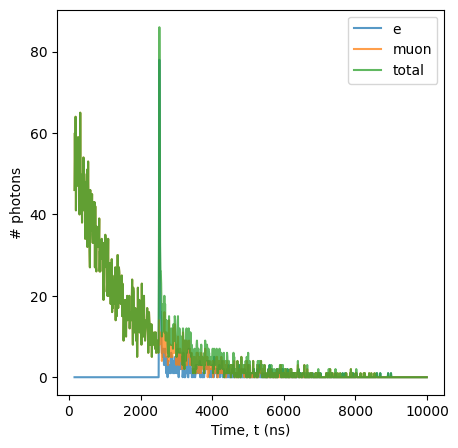

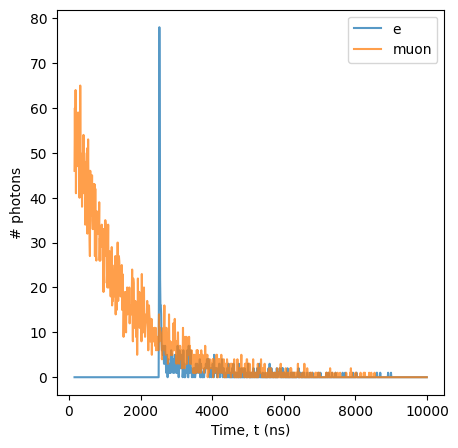

In [9]:
i = 4
print(idxs[i])
e_signal = np.array(e_signals.loc[idxs[i], t_idx]).reshape(-1)
mu_signal = np.array(mu_signals.loc[idxs[i], t_idx]).reshape(-1)
signal = np.array(signals.loc[idxs[i], t_idx]).reshape(-1)

v = [e_signal, mu_signal, signal]
plotSignals(t, v, ['e', 'muon', 'total'])

v = [e_signal, mu_signal]
plotSignals(t, v, ['e', 'muon'])

# Deep learning models

The first thing to know is how we should pass the data to a neural network and 
how to build its output layer. 

## Inputs and outputs

###  Using one time serie

For instance, let's imagine we have a neural network that only receives one 
time serie for the decomposition.  
In this case, the input dimension of the neural network is one since it only 
receives one array. Also, it only have one neural network to predict another 
array

In [12]:
from keras import Sequential
from keras.models import Model
from keras.layers import LSTM, Dense

i = 4
a = np.array(e_signals.loc[idxs[i], t_idx]).reshape(-1,1)
b = np.array(mu_signals.loc[idxs[i], t_idx]).reshape(-1,1)
total = np.array(signals.loc[idxs[i], t_idx]).reshape(-1,1)

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, activation = 'sigmoid', input_dim=1))
model.add(Dense(1, activation='linear'))

In [13]:
X = np.array(signals.loc[idxs[i], t_idx]).reshape(-1,1)
a = np.array(e_signals.loc[idxs[i], t_idx]).reshape(-1,1)
b = np.array(mu_signals.loc[idxs[i], t_idx]).reshape(-1,1)

In [14]:
np.shape(X)

(985, 1)

Epoch 1/100
28/28 [==============================] - 1s 6ms/step - loss: 13.9372 - val_loss: 0.0174
Epoch 2/100
28/28 [==============================] - 0s 2ms/step - loss: 13.1349 - val_loss: 0.1555
Epoch 3/100
28/28 [==============================] - 0s 4ms/step - loss: 12.8226 - val_loss: 0.2325
Epoch 4/100
28/28 [==============================] - 0s 2ms/step - loss: 12.7206 - val_loss: 0.2565
Epoch 5/100
28/28 [==============================] - 0s 1ms/step - loss: 12.6679 - val_loss: 0.2184
Epoch 6/100
28/28 [==============================] - 0s 1ms/step - loss: 12.6080 - val_loss: 0.1727
Epoch 7/100
28/28 [==============================] - 0s 1ms/step - loss: 12.5879 - val_loss: 0.1385
Epoch 8/100
28/28 [==============================] - 0s 1ms/step - loss: 12.5587 - val_loss: 0.1093
Epoch 9/100
28/28 [==============================] - 0s 1ms/step - loss: 12.5505 - val_loss: 0.0948
Epoch 10/100
28/28 [==============================] - 0s 1ms/step - loss: 12.5370 - val_loss: 0.0673

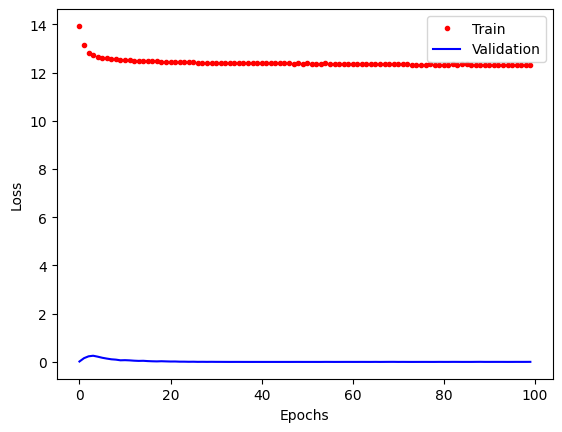

In [15]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X, a, batch_size=32, epochs=100, 
                    validation_split=0.1)

NN_trainPlot(history)

Obviously, the model is too simple to achieve a good result, in fact it is 
overfitting. By the moment, we are just learning what and how to give data to 
the model. 

31/31 [==============================] - 0s 587us/step


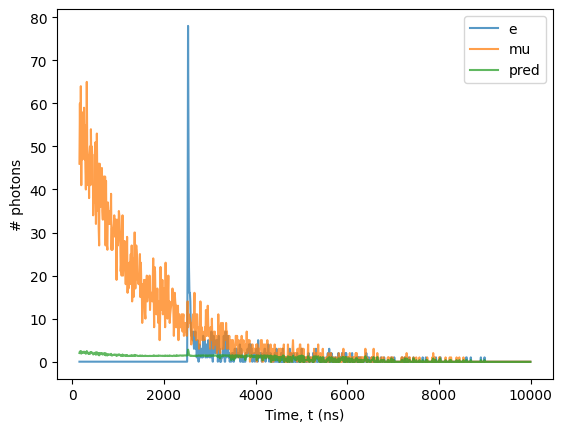

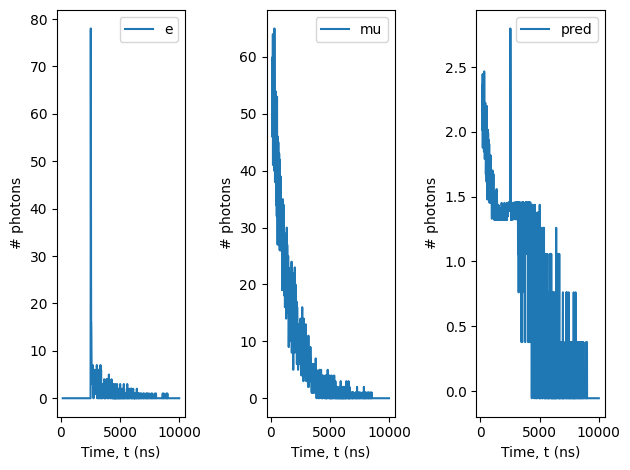

In [17]:
pred = model.predict(X)

v = [a, b, np.array(pred).reshape(-1,1)]
plotSignals(t, v, ['e', 'mu', 'pred'])
plotSignals(t, v, ['e', 'mu', 'pred'], sep=True)

Although it seems to predict where the electron is, we go a step further.

### All time series

Using one time serie does not generalize a model as much as we would want, and 
we can configure a NN to take all the data to train.  
That is exactly our next step.

We generate the training and test datasets:

In [10]:
from sklearn.model_selection import train_test_split
X = np.array(signals.iloc[:, t_idx].values) 
y = np.array(e_signals.iloc[:, t_idx].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    random_state=2023)

print(X_train.shape)
print(y_train.shape)

(6527, 985)
(6527, 985)


Due to the usage of LSTM layers, we must configure the shape of the inputs.  
Following the **keras** guide, the input shape of the train dataset must be: 
$$(number\_of\_samples,\ number\_of\_timesteps,\ number\_of\_features).$$

In this moment only have one feature, so we only add a new axis to `X`:

In [11]:
X_train = X_train[:, :, np.newaxis]

timesteps = int(X_train.shape[1])
features = int(X_train.shape[2])
input_shape = (timesteps,features)

print(input_shape)

(985, 1)


The only thing missing is the **output layer configuration**. We will give a dataset 
X_test to the NN after the training and its output must be one time serie for 
each sample with the same timesteps.  

To achieve it, we will configure the NN with LSTM layers having the parameter 
`return_sequences=True`. This way, the LSTM output is the evaluation at each 
timestep.  
Also, we are configuring one output `Dense` layer with one neuron and linear 
function activation to give the prediction.

Epoch 1/2
143/143 [==============================] - 27s 189ms/step - loss: 2.7269 - val_loss: 2.6790
Epoch 2/2
143/143 [==============================] - 27s 188ms/step - loss: 2.6635 - val_loss: 2.6375


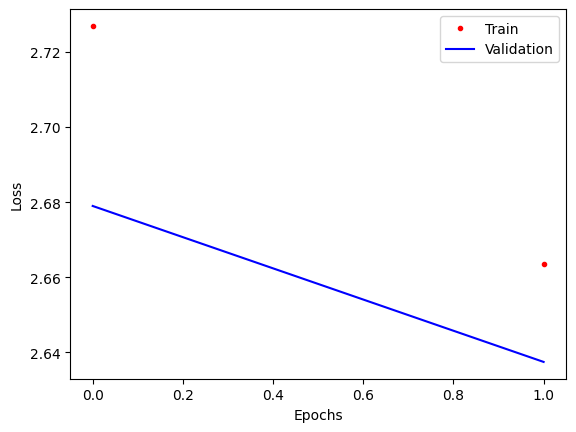

In [15]:
from keras import Sequential
from keras.layers import LSTM, Dense
from keras.utils import set_random_seed

set_random_seed(2023)
model = Sequential()
model.add(LSTM(units=64, activation = 'sigmoid', return_sequences=True,
               input_shape=input_shape))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=2, 
          validation_split=0.3)

NN_trainPlot(history)

In [16]:
y_pred = model.predict(X_test[:,:, np.newaxis]) 

88/88 [==============================] - 4s 44ms/step


In [17]:
np.shape(y_pred)

(2798, 985, 1)

As we can see, the output prediction has the shape we need, 
$$(number\_of\_test\_samples,\ number\_of\_timesteps, 1).$$

Let's check a random prediction:

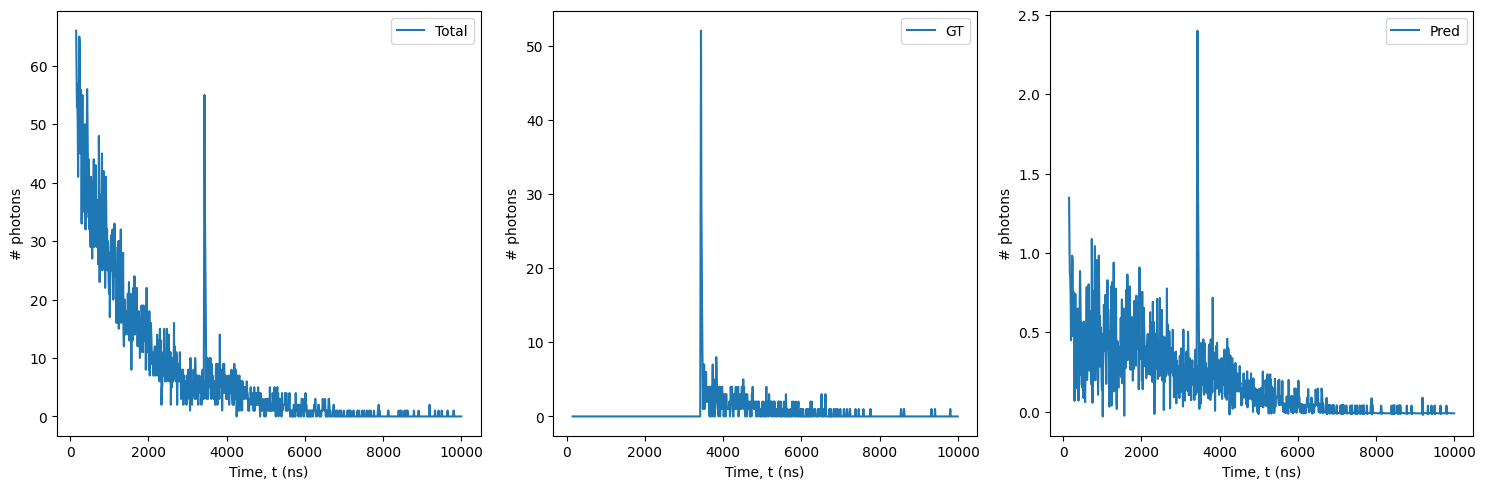

In [18]:
y_pred = y_pred[:,:,0]
i=5
v = [X_test[i,:], y_test[i,:], np.array(y_pred[i,:])]
plotSignals(t, v, ['Total', 'GT', 'Pred'], sep='True', figsize=(15,5))

As we can see, this model is too little to reproduce the results, we would need 
a bigger model to improve the signal decomposition.  
**However, we have achieved what we wanted, now, we know how to configure a NN to 
receive our data and produce results.**

## Models

It's time to create bigger models and to use the art state to solve this 
problem.

Function to test a model: 

In [10]:
def testModel(model, history, X_test, y_test, plot=True):

    if history!=None: 
        NN_trainPlot(history)

    y_pred = model.predict(X_test) 
    y_pred = y_pred[:,:,0] # adjust to (n_samples, n_timesteps)

    if plot:
        i=5
        v = [X_test[i,:,0], y_test[i,:], np.array(y_pred[i,:])]
        plotSignals(t, v, ['Total', 'GT', 'Pred'], sep='True', figsize=(15,5))

    e_found = 0
    for GT, pred in zip(y_test, y_pred): 
        q = quality(t, GT, pred)
        if q.isElectronExctracted(): e_found+=1

    print('Ratio e total found: {0}%'.format(e_found / y_test.shape[0] * 100))

### Model: simple LSTM (bidirectional)

We are recreating in each model the train and test folders in order to be able 
of training models separately.

In [11]:
from sklearn.model_selection import train_test_split
X = np.array(signals.iloc[:, t_idx].values) 
y = np.array(e_signals.iloc[:, t_idx].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    random_state=2023)

X_train = X_train[:, :, np.newaxis].astype('float64')
y_train = y_train.astype('float64')

X_test = X_test[:,:, np.newaxis].astype('float64')
y_test = y_test.astype('float64')

In [12]:
timesteps = int(X_train.shape[1])
features = int(X_train.shape[2])
input_shape = (timesteps,features)

print(input_shape)

(985, 1)


First, we will use a simple bidirectional layer to see if its behaviour:

In [13]:
from keras import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from keras.utils import set_random_seed

def model_SimpleBidirectional(n_hidden_layers=1, n_neurons=[16], 
                              activation=['tanh'], timesteps=985, features=1, 
                              seed=2023):

    set_random_seed(seed)
    
    init = True
    input_shape=(timesteps, features)

    model = Sequential()
    for i in range(n_hidden_layers): 
        if init: 
            # also adds the input layer
            model.add(Bidirectional(LSTM(units = n_neurons[i], 
                                         activation = activation[i], 
                                         return_sequences=True,
                                         input_shape = input_shape
                                         ))) 
            init=False
            
        else: 
            model.add(Bidirectional(LSTM(units = n_neurons[i], 
                                         activation = activation[i], 
                                         return_sequences=True)))
    
    model.add(Dense(1, activation='linear')) # output layer
    
    return model

Epoch 1/10
143/143 [==============================] - 36s 245ms/step - loss: 2.7117 - val_loss: 2.6625
Epoch 2/10
143/143 [==============================] - 44s 311ms/step - loss: 2.6359 - val_loss: 2.6052
Epoch 3/10
143/143 [==============================] - 45s 315ms/step - loss: 2.5791 - val_loss: 2.5457
Epoch 4/10
143/143 [==============================] - 45s 318ms/step - loss: 2.5243 - val_loss: 2.4864
Epoch 5/10
143/143 [==============================] - 47s 326ms/step - loss: 2.4600 - val_loss: 2.4303
Epoch 6/10
143/143 [==============================] - 43s 304ms/step - loss: 2.3859 - val_loss: 2.3303
Epoch 7/10
143/143 [==============================] - 44s 308ms/step - loss: 2.2896 - val_loss: 2.2326
Epoch 8/10
143/143 [==============================] - 45s 313ms/step - loss: 2.1829 - val_loss: 2.1372
Epoch 9/10
143/143 [==============================] - 44s 307ms/step - loss: 2.0718 - val_loss: 2.0264
Epoch 10/10
143/143 [==============================] - 45s 314ms/step - l

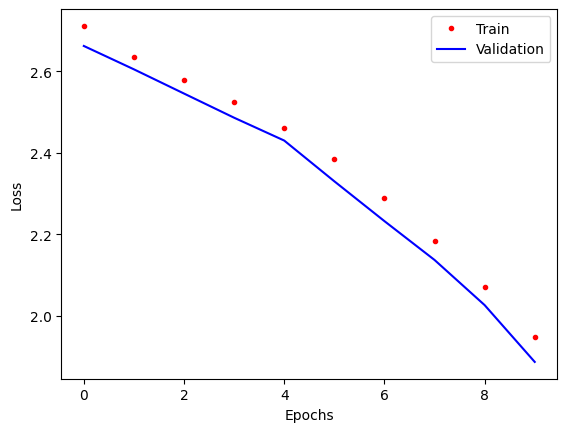

88/88 [==============================] - 5s 61ms/step


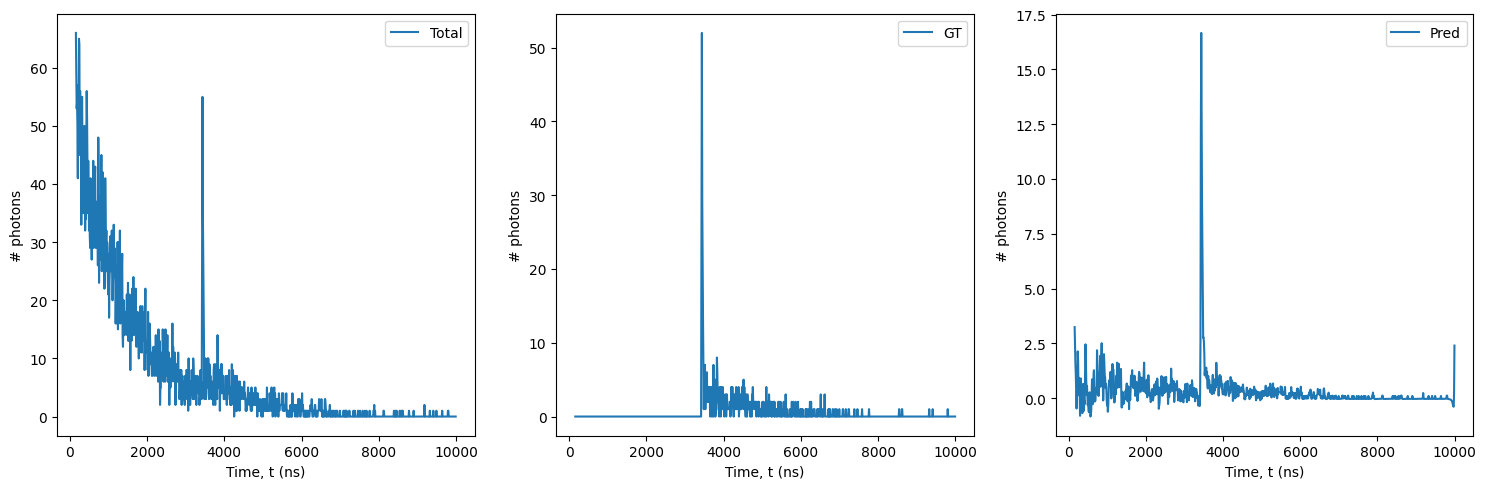

Ratio e total found: 50.964974982130094%


In [14]:
model = model_SimpleBidirectional(n_hidden_layers=1, 
                                  n_neurons=[64], 
                                  activation=['sigmoid'], 
                                  timesteps=timesteps, 
                                  features=features)

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, 
                    validation_split=0.3)

testModel(model, history, X_test, y_test)

Comment results

Epoch 1/10
143/143 [==============================] - 31s 207ms/step - loss: 2.6529 - val_loss: 2.5548
Epoch 2/10
143/143 [==============================] - 29s 202ms/step - loss: 2.4850 - val_loss: 2.4097
Epoch 3/10
143/143 [==============================] - 28s 199ms/step - loss: 2.2897 - val_loss: 2.2564
Epoch 4/10
143/143 [==============================] - 29s 200ms/step - loss: 2.0817 - val_loss: 2.0552
Epoch 5/10
143/143 [==============================] - 29s 206ms/step - loss: 1.9548 - val_loss: 1.8514
Epoch 6/10
143/143 [==============================] - 29s 204ms/step - loss: 1.7232 - val_loss: 1.6429
Epoch 7/10
143/143 [==============================] - 29s 203ms/step - loss: 1.6487 - val_loss: 1.5200
Epoch 8/10
143/143 [==============================] - 29s 203ms/step - loss: 1.4576 - val_loss: 1.9410
Epoch 9/10
143/143 [==============================] - 29s 205ms/step - loss: 1.5473 - val_loss: 1.4335
Epoch 10/10
143/143 [==============================] - 29s 205ms/step - l

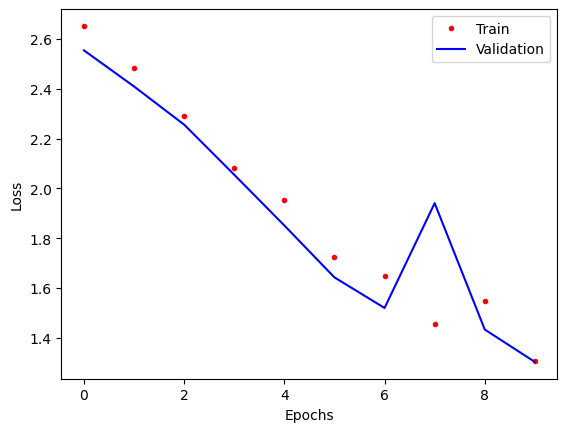

88/88 [==============================] - 4s 45ms/step


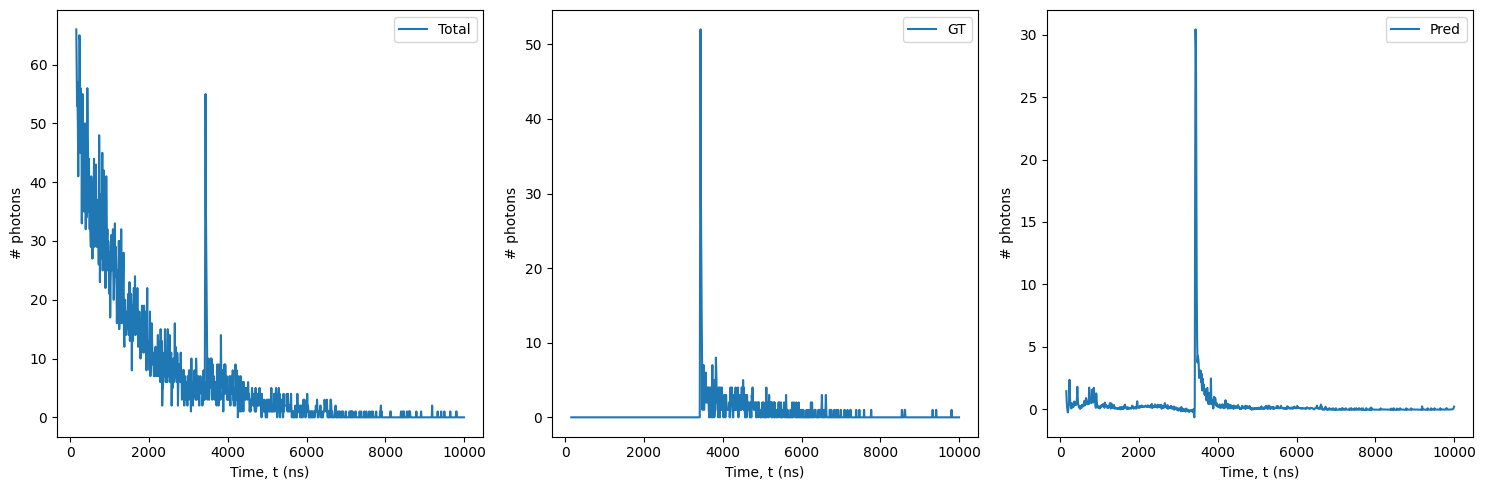

Ratio e total found: 47.140814867762685%


In [15]:
model = model_SimpleBidirectional(n_hidden_layers=1, 
                                  n_neurons=[64], 
                                  activation=['tanh'], 
                                  timesteps=timesteps, 
                                  features=features)

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, 
                    validation_split=0.3)

testModel(model, history, X_test, y_test)

It seems that the activation `tanh` works better. 
Also, looking at the history plot, we can see that the model could achieve a 
better loss. 

Now, we test another optimizer:

Epoch 1/10
143/143 [==============================] - 30s 201ms/step - loss: 2.6639 - val_loss: 2.6138
Epoch 2/10
143/143 [==============================] - 28s 195ms/step - loss: 2.5285 - val_loss: 2.4322
Epoch 3/10
143/143 [==============================] - 28s 197ms/step - loss: 2.4369 - val_loss: 2.3632
Epoch 4/10
143/143 [==============================] - 29s 206ms/step - loss: 2.2651 - val_loss: 2.3408
Epoch 5/10
143/143 [==============================] - 29s 205ms/step - loss: 2.1446 - val_loss: 2.0824
Epoch 6/10
143/143 [==============================] - 29s 201ms/step - loss: 2.0281 - val_loss: 1.9541
Epoch 7/10
143/143 [==============================] - 29s 202ms/step - loss: 1.8355 - val_loss: 1.7532
Epoch 8/10
143/143 [==============================] - 29s 200ms/step - loss: 1.6811 - val_loss: 1.6229
Epoch 9/10
143/143 [==============================] - 29s 200ms/step - loss: 1.5684 - val_loss: 1.5403
Epoch 10/10
143/143 [==============================] - 29s 200ms/step - l

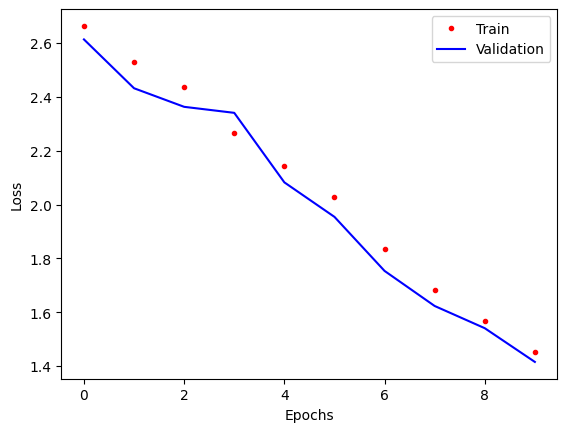

88/88 [==============================] - 4s 45ms/step


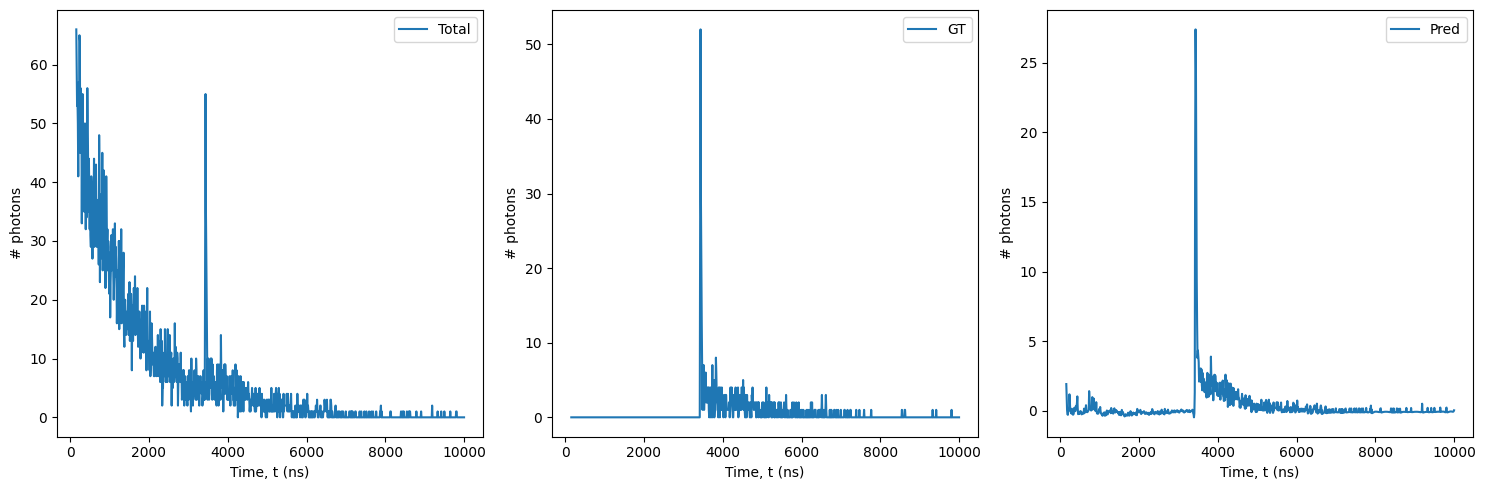

Ratio e total found: 55.28949249463903%


In [16]:
model = model_SimpleBidirectional(n_hidden_layers=1, 
                                  n_neurons=[64], 
                                  activation=['tanh'], 
                                  timesteps=timesteps, 
                                  features=features)

model.compile(optimizer='RMSprop', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, 
                    validation_split=0.3)

testModel(model, history, X_test, y_test)

Let's test another optimizer: 

Epoch 1/10
143/143 [==============================] - 31s 206ms/step - loss: 2.7184 - val_loss: 2.7036
Epoch 2/10
143/143 [==============================] - 29s 200ms/step - loss: 2.6907 - val_loss: 2.6726
Epoch 3/10
143/143 [==============================] - 28s 199ms/step - loss: 2.6714 - val_loss: 2.6598
Epoch 4/10
143/143 [==============================] - 28s 198ms/step - loss: 2.6549 - val_loss: 2.6416
Epoch 5/10
143/143 [==============================] - 28s 197ms/step - loss: 2.6362 - val_loss: 2.6405
Epoch 6/10
143/143 [==============================] - 28s 197ms/step - loss: 2.6209 - val_loss: 2.6000
Epoch 7/10
143/143 [==============================] - 27s 190ms/step - loss: 2.6061 - val_loss: 2.5795
Epoch 8/10
143/143 [==============================] - 27s 191ms/step - loss: 2.5884 - val_loss: 2.5982
Epoch 9/10
143/143 [==============================] - 28s 196ms/step - loss: 2.5768 - val_loss: 2.5825
Epoch 10/10
143/143 [==============================] - 27s 191ms/step - l

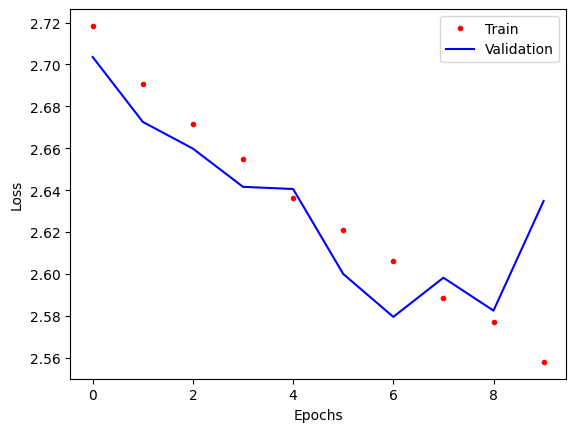

88/88 [==============================] - 4s 44ms/step


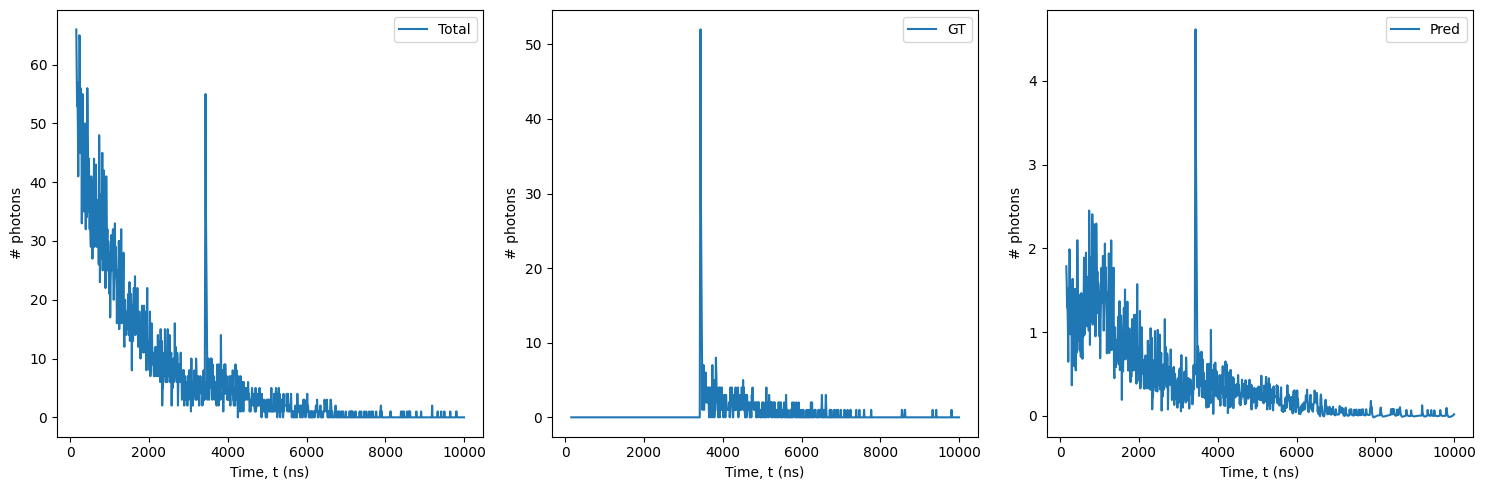

Ratio e total found: 36.09721229449607%


In [17]:
model = model_SimpleBidirectional(n_hidden_layers=1, 
                                  n_neurons=[64], 
                                  activation=['tanh'], 
                                  timesteps=timesteps, 
                                  features=features)

model.compile(optimizer='SGD', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, 
                    validation_split=0.3)

testModel(model, history, X_test, y_test)

After watching all the results of several executions we create a table to 
compare them: 

<center>

|Model        |e found ratio |MSE
|:-----------:|:------------:|---------|
|sigmoid/adam |~51%          |1.89
|tanh/adam    |~47%          |1.30
|tanh/RMSprop |~55%          |1.41
|tanh/SGD     |~36%          |2.63


The best two models are those with the `tanh` function activation and the 
optimize `adam` and `RMSprop`.  
Instead of taking only one of them, we train them again with more epochs. After 
all, the trend pointed out that they could improve more.

Epoch 1/50
143/143 [==============================] - 32s 213ms/step - loss: 2.6529 - val_loss: 2.5548
Epoch 2/50
143/143 [==============================] - 30s 211ms/step - loss: 2.4850 - val_loss: 2.4097
Epoch 3/50
143/143 [==============================] - 30s 212ms/step - loss: 2.2897 - val_loss: 2.2564
Epoch 4/50
143/143 [==============================] - 30s 213ms/step - loss: 2.0817 - val_loss: 2.0552
Epoch 5/50
143/143 [==============================] - 31s 214ms/step - loss: 1.9548 - val_loss: 1.8514
Epoch 6/50
143/143 [==============================] - 31s 216ms/step - loss: 1.7232 - val_loss: 1.6429
Epoch 7/50
143/143 [==============================] - 31s 215ms/step - loss: 1.6487 - val_loss: 1.5200
Epoch 8/50
143/143 [==============================] - 31s 215ms/step - loss: 1.4576 - val_loss: 1.9410
Epoch 9/50
143/143 [==============================] - 30s 211ms/step - loss: 1.5473 - val_loss: 1.4335
Epoch 10/50
143/143 [==============================] - 32s 222ms/step - l

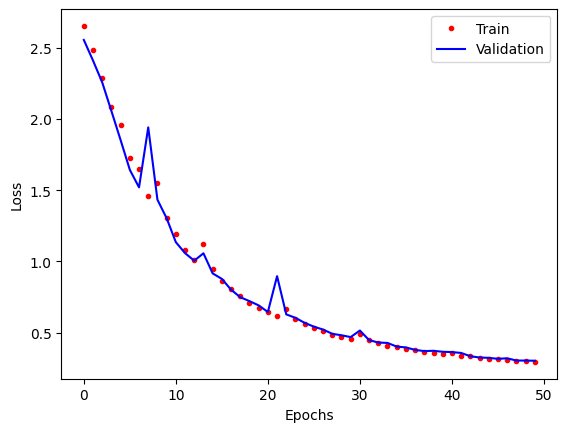

88/88 [==============================] - 4s 46ms/step


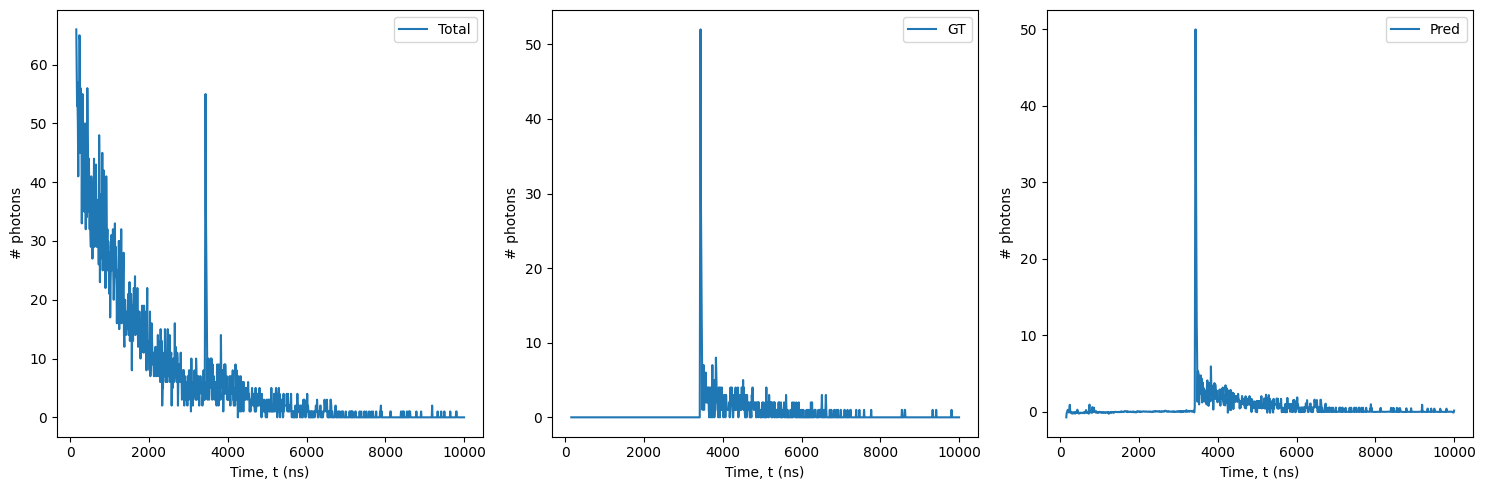

Ratio e total found: 47.212294496068616%


In [15]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, 
                         mode='auto')

model = model_SimpleBidirectional(n_hidden_layers=1, 
                                  n_neurons=[64], 
                                  activation=['tanh'], 
                                  timesteps=timesteps, 
                                  features=features)

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=50, 
                    validation_split=0.3, callbacks=callback)

testModel(model, history, X_test, y_test)

Epoch 1/50
143/143 [==============================] - 32s 212ms/step - loss: 2.6639 - val_loss: 2.6138
Epoch 2/50
143/143 [==============================] - 31s 214ms/step - loss: 2.5285 - val_loss: 2.4322
Epoch 3/50
143/143 [==============================] - 31s 217ms/step - loss: 2.4369 - val_loss: 2.3632
Epoch 4/50
143/143 [==============================] - 31s 216ms/step - loss: 2.2651 - val_loss: 2.3408
Epoch 5/50
143/143 [==============================] - 30s 212ms/step - loss: 2.1446 - val_loss: 2.0824
Epoch 6/50
143/143 [==============================] - 30s 213ms/step - loss: 2.0281 - val_loss: 1.9541
Epoch 7/50
143/143 [==============================] - 30s 212ms/step - loss: 1.8355 - val_loss: 1.7532
Epoch 8/50
143/143 [==============================] - 30s 213ms/step - loss: 1.6811 - val_loss: 1.6229
Epoch 9/50
143/143 [==============================] - 30s 209ms/step - loss: 1.5684 - val_loss: 1.5403
Epoch 10/50
143/143 [==============================] - 31s 215ms/step - l

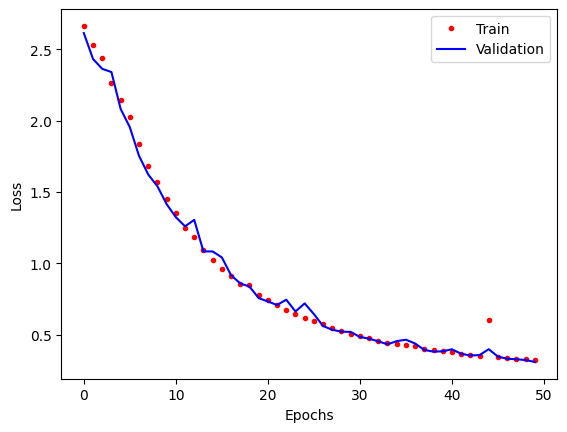

88/88 [==============================] - 4s 47ms/step


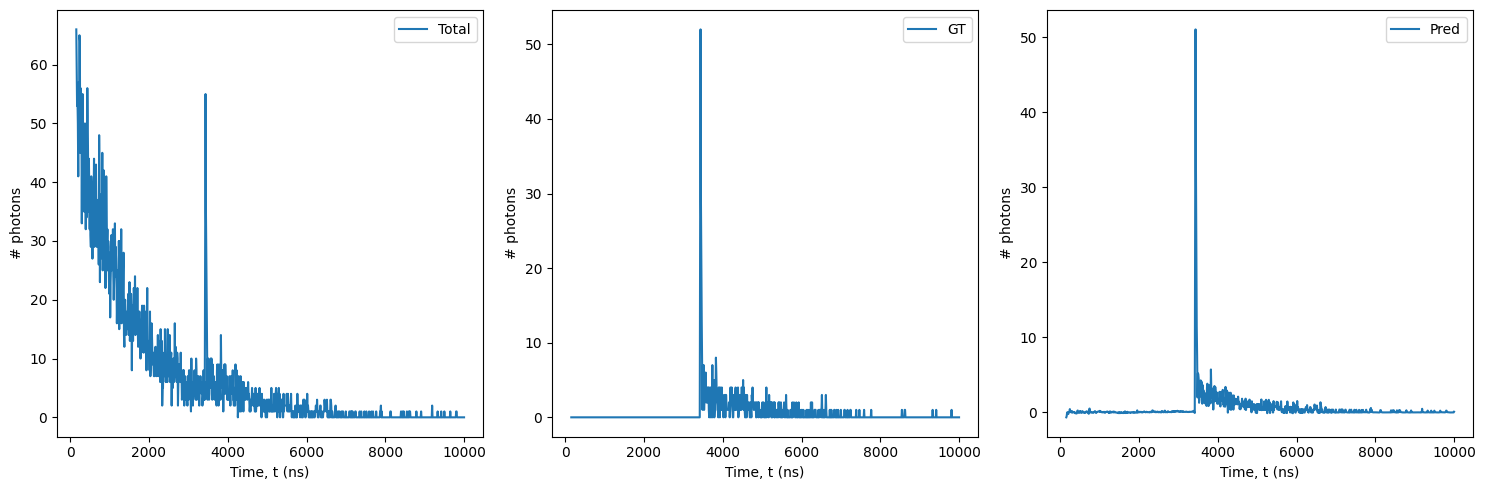

Ratio e total found: 49.714081486776266%


In [17]:
callback = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, 
                         mode='auto')

model = model_SimpleBidirectional(n_hidden_layers=1, 
                                  n_neurons=[64], 
                                  activation=['tanh'], 
                                  timesteps=timesteps, 
                                  features=features)

model.compile(optimizer='RMSprop', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=50, 
                    validation_split=0.3, callbacks=callback)

testModel(model, history, X_test, y_test)

After watching these last results, we conclude that these models cannot improve
the ratio of electron found with more epochs. This training just enhance the 
quality of the signal extracted.  
Hence, we take the last of the models and we save it.

#### Saving best model

In [23]:
MODELS = os.path.join(PATH, os.path.join('scripts', os.path.join('python', 'models')))
model.save(os.path.join(MODELS, 'best_Bidir_LSTM_Simple.keras'), overwrite=True, 
           save_format='tf')

Check it is well saved: 

In [13]:
from keras.saving import load_model

MODELS = os.path.join(PATH, os.path.join('scripts', os.path.join('python', 'models')))
model_test = load_model(os.path.join(MODELS, 'best_Bidir_LSTM_Simple.keras'))

y_pred = model_test.predict(X_test)

88/88 [==============================] - 4s 46ms/step


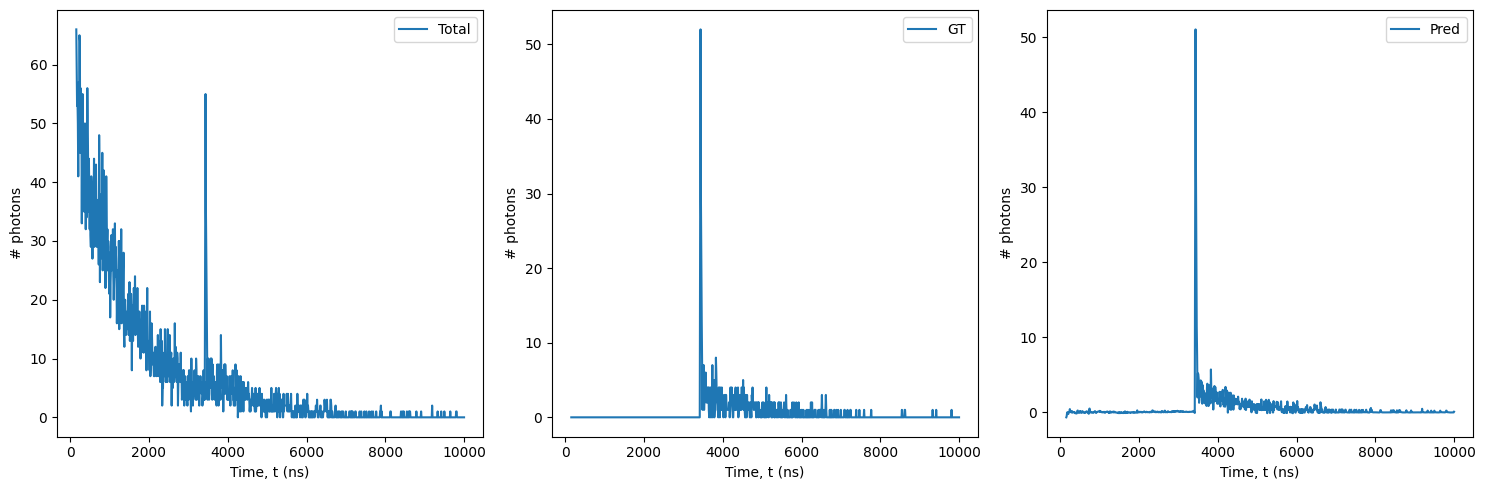

In [14]:
i=5
v = [X_test[i,:,0], y_test[i,:], np.array(y_pred[i,:])]
plotSignals(t, v, ['Total', 'GT', 'Pred'], sep='True', figsize=(15,5))

#### Test with reduced data

Finally, we test the selected model above those signals where the electron has 
a peak of at least 5 electrons:

In [15]:
max_photons = 5
max_values = e_signals.max(axis=1)

mask = max_values > max_photons # True those with a maximum > max_photons
e_idxs = mask[mask==True].index.values

print('Total series: ', e_signals.shape[0])
print('Number of e signals with a max>{0}: {1}'.format(max_photons, e_idxs.shape[0]))

Total series:  9325
Number of e signals with a max>5: 4223


In [16]:
Xf = np.array(signals.loc[e_idxs, t_idx].values)
yf = np.array(e_signals.loc[e_idxs, t_idx].values)

132/132 [==============================] - 6s 45ms/step


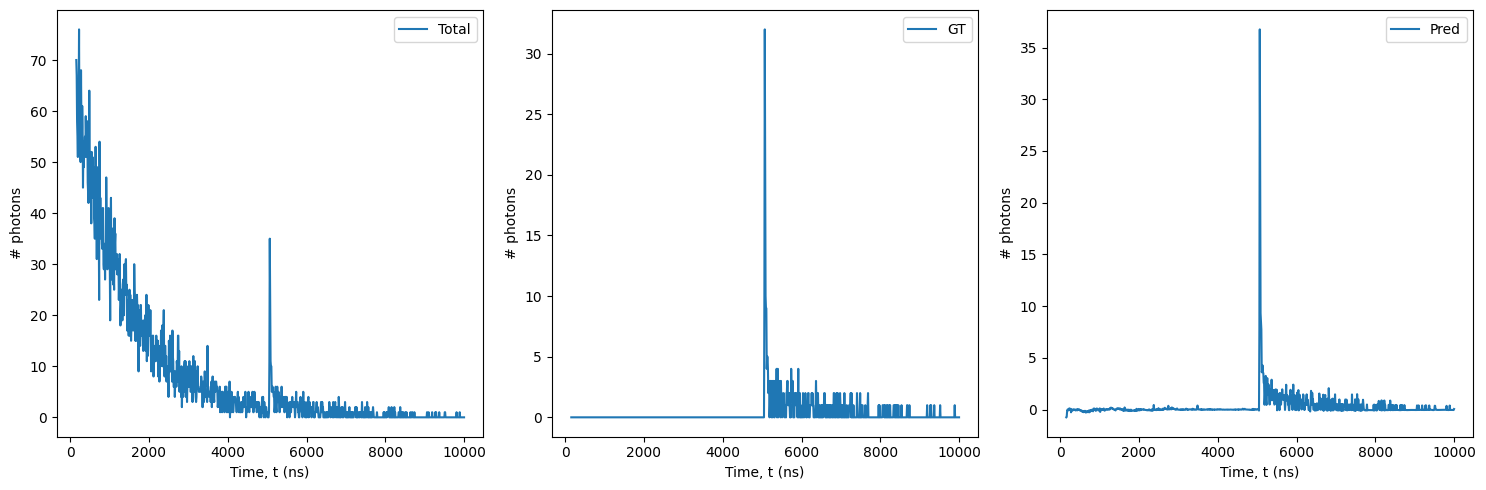

Ratio e total found: 81.22188017996685%


In [18]:
testModel(model_test, None, Xf[:,:,np.newaxis].astype('float64'), yf)

Let's test with a cross validation...

In [36]:
k=8
for i in range(k): 
    print(f'Cross validation: {i+1}/{k}')
    Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf, 
                                                            test_size=0.3,
                                                            random_state=2023+i)
    
    y_pred = model.predict(Xf_test[:,:,np.newaxis].astype('float64'))
    
    e_found = 0
    for GT, pred in zip(yf_test, y_pred): 
        q = quality(t, GT, pred)
        if q.isElectronExctracted(): e_found+=1
        
    print('Ratio e total found: {0}%\n'.format(e_found / yf_test.shape[0] * 100))

Cross validation: 1/8
40/40 [==============================] - 2s 45ms/step
Ratio e total found: 80.97868981846882%

Cross validation: 2/8
40/40 [==============================] - 2s 46ms/step
Ratio e total found: 81.53117600631413%

Cross validation: 3/8
40/40 [==============================] - 2s 45ms/step
Ratio e total found: 80.18942383583267%

Cross validation: 4/8
40/40 [==============================] - 2s 46ms/step
Ratio e total found: 81.68902920284135%

Cross validation: 5/8
40/40 [==============================] - 2s 46ms/step
Ratio e total found: 81.13654301499605%

Cross validation: 6/8
40/40 [==============================] - 2s 45ms/step
Ratio e total found: 80.34727703235991%

Cross validation: 7/8
40/40 [==============================] - 2s 47ms/step
Ratio e total found: 80.03157063930544%

Cross validation: 8/8
40/40 [==============================] - 2s 46ms/step
Ratio e total found: 82.63614838200473%



### Model: complex LSTM (bidirectional)

Now, we add more hidden layers.  
Again, we recreate data:

In [12]:
from sklearn.model_selection import train_test_split
X = np.array(signals.iloc[:, t_idx].values) 
y = np.array(e_signals.iloc[:, t_idx].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    random_state=2023)

X_train = X_train[:, :, np.newaxis].astype('float64')
y_train = y_train.astype('float64')

X_test = X_test[:,:, np.newaxis].astype('float64')
y_test = y_test.astype('float64')

timesteps = int(X_train.shape[1])
features = int(X_train.shape[2])
input_shape = (timesteps,features)

print(input_shape)

(985, 1)


In [15]:
from keras import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from keras.utils import set_random_seed
from keras.callbacks import EarlyStopping

def LSTMBidirectional(n_hidden_layers=2, n_neurons=[16,16], 
                      activation=['tanh', 'tanh'], timesteps=985, features=1, 
                      seed=2023):

    set_random_seed(seed)
    
    init = True
    input_shape=(timesteps, features)

    model = Sequential()
    for i in range(n_hidden_layers): 
        if init: 
            # also adds the input layer
            model.add(Bidirectional(LSTM(units = n_neurons[i], 
                                         activation = activation[i], 
                                         return_sequences=True,
                                         input_shape = input_shape
                                         ))) 
            init=False
            
        else: 
            model.add(Bidirectional(LSTM(units = n_neurons[i], 
                                         activation = activation[i], 
                                         return_sequences=True)))
    
    model.add(Dense(1, activation='linear')) # output layer
    
    return model

We create models adding more hidden layers with the structure of those that 
won in the simplex model:

Epoch 1/10
143/143 [==============================] - 43s 281ms/step - loss: 2.7304 - val_loss: 2.6925
Epoch 2/10
143/143 [==============================] - 40s 277ms/step - loss: 2.6377 - val_loss: 2.5814
Epoch 3/10
143/143 [==============================] - 39s 272ms/step - loss: 2.5316 - val_loss: 2.4706
Epoch 4/10
143/143 [==============================] - 39s 274ms/step - loss: 2.4209 - val_loss: 2.4398
Epoch 5/10
143/143 [==============================] - 39s 274ms/step - loss: 2.3363 - val_loss: 2.4111
Epoch 6/10
143/143 [==============================] - 39s 273ms/step - loss: 2.2982 - val_loss: 2.2533
Epoch 7/10
143/143 [==============================] - 39s 275ms/step - loss: 2.1816 - val_loss: 2.1250
Epoch 8/10
143/143 [==============================] - 39s 276ms/step - loss: 2.0676 - val_loss: 2.0207
Epoch 9/10
143/143 [==============================] - 39s 276ms/step - loss: 1.9535 - val_loss: 1.9349
Epoch 10/10
143/143 [==============================] - 39s 275ms/step - l

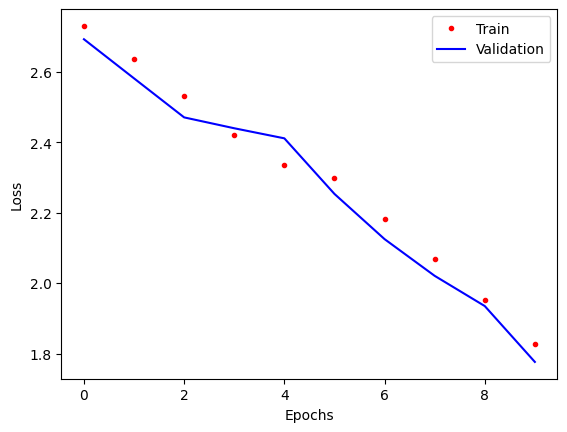

88/88 [==============================] - 5s 46ms/step


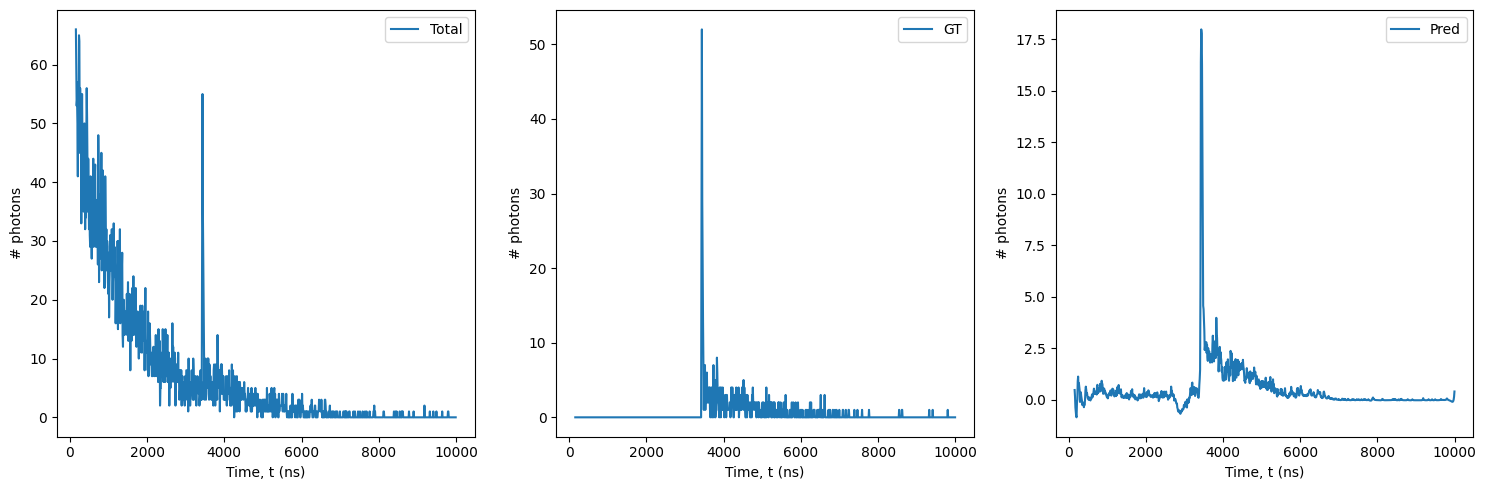

Ratio e total found: 48.32022873481058%


In [16]:
callback = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, 
                         mode='auto')

model = LSTMBidirectional(n_hidden_layers=2, 
                          n_neurons=[16,16],
                          activation=['tanh', 'tanh'],
                          timesteps=timesteps,
                          features=features)

model.compile(optimizer='RMSprop', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, 
                    validation_split=0.3, callbacks=callback)

testModel(model, history, X_test, y_test)

Epoch 1/10
143/143 [==============================] - 133s 914ms/step - loss: 2.6298 - val_loss: 2.5337
Epoch 2/10
143/143 [==============================] - 126s 879ms/step - loss: 1.9387 - val_loss: 1.6189
Epoch 3/10
143/143 [==============================] - 130s 909ms/step - loss: 1.4507 - val_loss: 1.2409
Epoch 4/10
143/143 [==============================] - 127s 889ms/step - loss: 1.1230 - val_loss: 1.1163
Epoch 5/10
143/143 [==============================] - 131s 919ms/step - loss: 0.8963 - val_loss: 0.8235
Epoch 6/10
143/143 [==============================] - 130s 911ms/step - loss: 0.7242 - val_loss: 0.6499
Epoch 7/10
143/143 [==============================] - 127s 893ms/step - loss: 0.6104 - val_loss: 0.6161
Epoch 8/10
143/143 [==============================] - 135s 942ms/step - loss: 0.5136 - val_loss: 0.4834
Epoch 9/10
143/143 [==============================] - 127s 886ms/step - loss: 0.4434 - val_loss: 0.4242
Epoch 10/10
143/143 [==============================] - 134s 937m

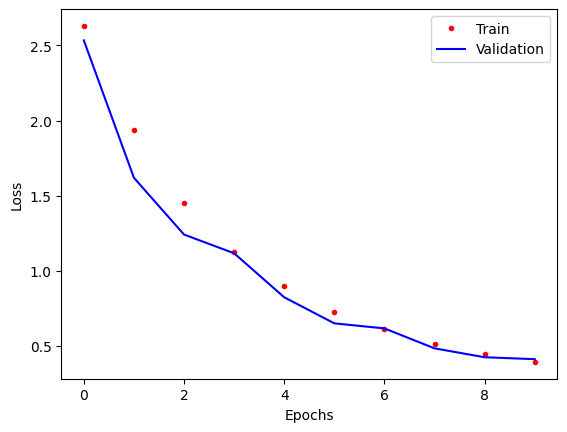

88/88 [==============================] - 17s 183ms/step


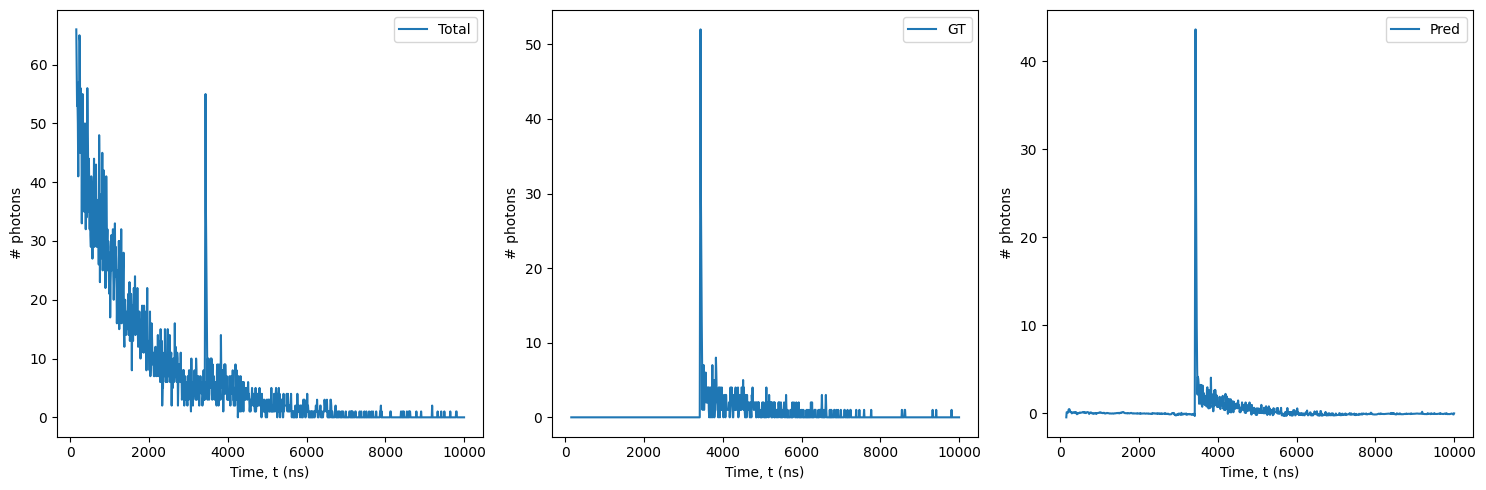

Ratio e total found: 60.15010721944246%


In [17]:
callback = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True, 
                         mode='auto')

model = LSTMBidirectional(n_hidden_layers=2, 
                          n_neurons=[64,64],
                          activation=['tanh', 'tanh'],
                          timesteps=timesteps,
                          features=features)

model.compile(optimizer='RMSprop', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, 
                    validation_split=0.3, callbacks=callback)

testModel(model, history, X_test, y_test)

In [18]:
MODELS = os.path.join(PATH, os.path.join('scripts', os.path.join('python', 'models')))
model.save(os.path.join(MODELS, '2layers_Bidir_LSTM_Complex.keras'), overwrite=True, 
           save_format='tf')

Epoch 1/10
143/143 [==============================] - 207s 1s/step - loss: 2.5174 - val_loss: 2.0941
Epoch 2/10
143/143 [==============================] - 191s 1s/step - loss: 1.6258 - val_loss: 1.3188
Epoch 3/10
143/143 [==============================] - 191s 1s/step - loss: 1.1633 - val_loss: 0.9896
Epoch 4/10
143/143 [==============================] - 189s 1s/step - loss: 0.8934 - val_loss: 0.8159
Epoch 5/10
143/143 [==============================] - 198s 1s/step - loss: 0.7017 - val_loss: 0.6204
Epoch 6/10
143/143 [==============================] - 195s 1s/step - loss: 0.5712 - val_loss: 0.5142
Epoch 7/10
143/143 [==============================] - 194s 1s/step - loss: 0.4774 - val_loss: 0.4436
Epoch 8/10
143/143 [==============================] - 197s 1s/step - loss: 0.4078 - val_loss: 0.3949
Epoch 9/10
143/143 [==============================] - 205s 1s/step - loss: 0.3572 - val_loss: 0.3266
Epoch 10/10
143/143 [==============================] - 205s 1s/step - loss: 0.3303 - val_lo

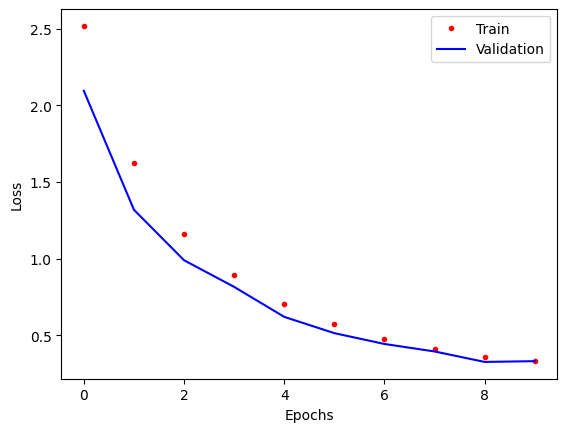

88/88 [==============================] - 25s 271ms/step


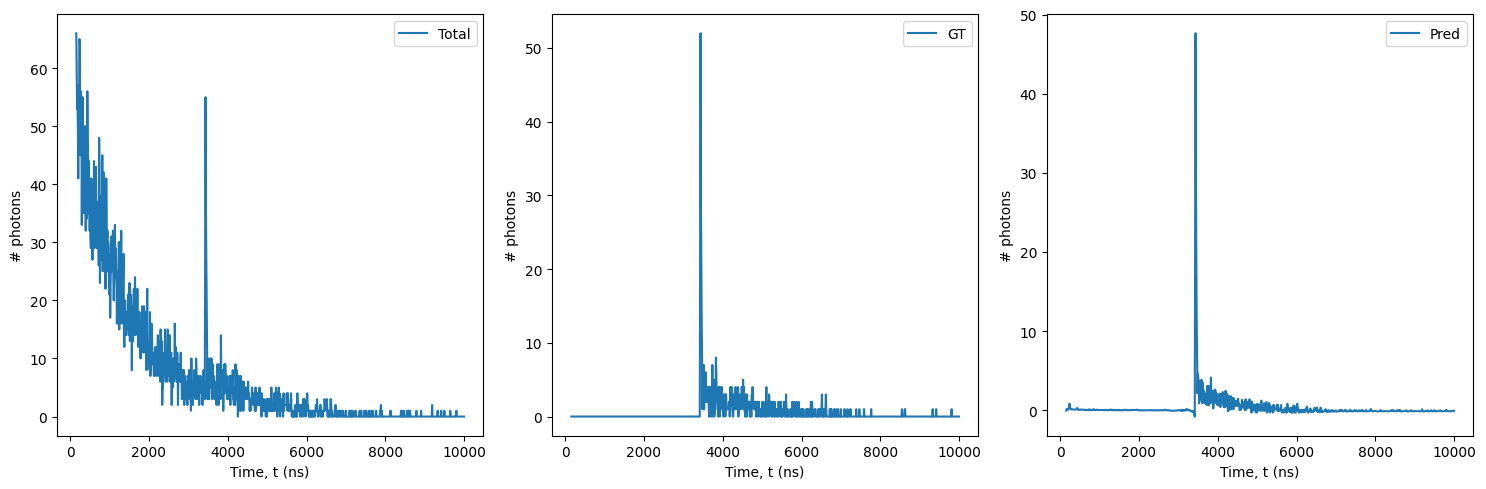

Ratio e total found: 56.25446747676912%


In [19]:
callback = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True, 
                         mode='auto')

model = LSTMBidirectional(n_hidden_layers=3, 
                          n_neurons=[64,64,64],
                          activation=['tanh', 'tanh', 'tanh'],
                          timesteps=timesteps,
                          features=features)

model.compile(optimizer='RMSprop', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, 
                    validation_split=0.3, callbacks=callback)

testModel(model, history, X_test, y_test)

In [20]:
MODELS = os.path.join(PATH, os.path.join('scripts', os.path.join('python', 'models')))
model.save(os.path.join(MODELS, '3layers_Bidir_LSTM_Complex.keras'), overwrite=True, 
           save_format='tf')

Table to compare results: 

<center>

|neurons/activation/optimizer  |epochs |e found ratio |MSE
|:-----------------------------|:------:|:------------:|---------|
|[16,16]/[tanh, tanh]/RMSprop  |10     |~48%          |1.77 
|[64,64]/[tanh, tanh]/RMSprop  |10     |~60%          |0.41 
|[64,64,64]/[tanh, tanh, tanh]/RMSprop  |10     |~56%          |0.33

#### Test with reduced data

Now, we test the last two models in the reduced data: 

In [11]:
max_photons = 5
max_values = e_signals.max(axis=1)

mask = max_values > max_photons # True those with a maximum > max_photons
e_idxs = mask[mask==True].index.values

print('Total series: ', e_signals.shape[0])
print('Number of e signals with a max>{0}: {1}'.format(max_photons, e_idxs.shape[0]))

Total series:  9325
Number of e signals with a max>5: 4223


In [12]:
Xf = np.array(signals.loc[e_idxs, t_idx].values)
yf = np.array(e_signals.loc[e_idxs, t_idx].values)

132/132 [==============================] - 22s 159ms/step


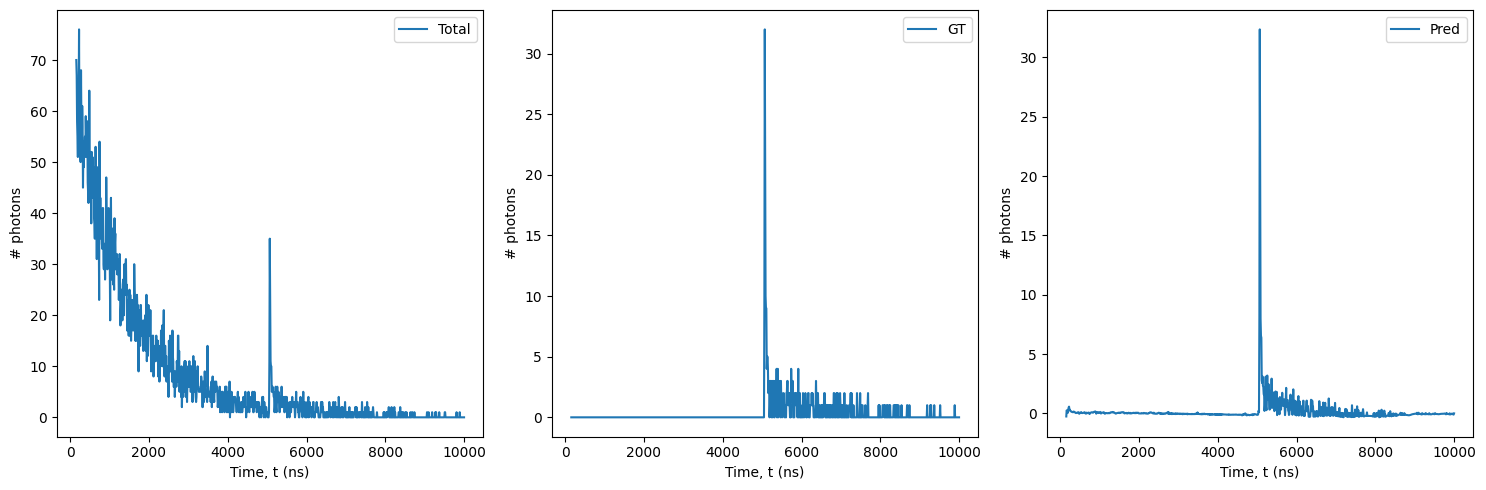

Ratio e total found: 82.59531139000711%


In [14]:
from keras.saving import load_model

MODELS = os.path.join(PATH, os.path.join('scripts', os.path.join('python', 'models')))
model = load_model(os.path.join(MODELS, '2layers_Bidir_LSTM_Complex.keras'))

testModel(model, None, Xf[:,:,np.newaxis].astype('float64'), yf)

132/132 [==============================] - 37s 277ms/step


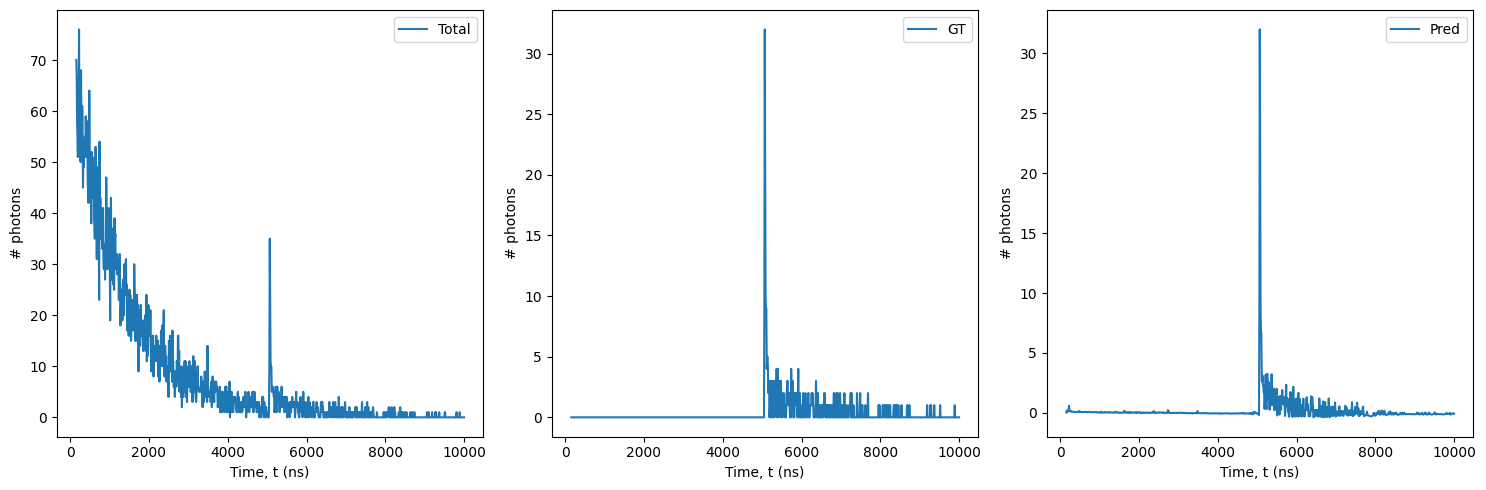

Ratio e total found: 84.32394032678191%


In [15]:
from keras.saving import load_model

MODELS = os.path.join(PATH, os.path.join('scripts', os.path.join('python', 'models')))
model = load_model(os.path.join(MODELS, '3layers_Bidir_LSTM_Complex.keras'))

testModel(model, None, Xf[:,:,np.newaxis].astype('float64'), yf)

These are amazing results.

### Others techniques

According to *Ioffe, S. & Szegedy, C.. (2015). Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift*,
the usage of normalization, we include Batch Normalization layers between the 
output of the LSTM layer and the activation function.  
In the paper *Cooijmans, T., Ballas, N. and all. (2017). RECURRENT BATCH NORMALIZATION*, 
there is also a demonstration how useful this approach is.

In [11]:
from sklearn.model_selection import train_test_split
X = np.array(signals.iloc[:, t_idx].values) 
y = np.array(e_signals.iloc[:, t_idx].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    random_state=2023)

X_train = X_train[:, :, np.newaxis].astype('float64')
y_train = y_train.astype('float64')

X_test = X_test[:,:, np.newaxis].astype('float64')
y_test = y_test.astype('float64')

timesteps = int(X_train.shape[1])
features = int(X_train.shape[2])
input_shape = (timesteps,features)

print(input_shape)

(985, 1)


In [12]:
from keras import Sequential
from keras.layers import LSTM, Dense, Bidirectional, BatchNormalization, Activation
from keras.activations import tanh
from keras.utils import set_random_seed
from keras.callbacks import EarlyStopping

def Add_Block_BN_BiLSTM(model, n_blocks=1, n_neurons=[16], activation = ['tanh'], 
                    input_shape=(985,1)):
    init = True
    
    for i in range(n_blocks):
        if init: 
            model.add(Bidirectional(LSTM(units = n_neurons[i], 
                                         return_sequences=True, 
                                         input_shape = input_shape))) 
            model.add(BatchNormalization())
            model.add(Activation(activation[i]))
            
        else: 
            model.add(Bidirectional(LSTM(units = n_neurons[i], 
                                         return_sequences=True))) 
            model.add(BatchNormalization())
            model.add(Activation(activation[i]))
                
    return model
        

def BN_Bidir_LSTM(n_blocks=1, n_neurons=[16], activation = ['tanh'], 
                  input_shape=(985,1)):
    set_random_seed(2023)
    
    model = Sequential()
    model = Add_Block_BN_BiLSTM(model, n_blocks, n_neurons, activation, input_shape)
    model.add(Dense(units=1, activation='linear'))
    
    return model

Epoch 1/10
143/143 [==============================] - 23s 151ms/step - loss: 2.6559 - val_loss: 2.7151
Epoch 2/10
143/143 [==============================] - 21s 148ms/step - loss: 2.5268 - val_loss: 2.9575
Epoch 3/10
143/143 [==============================] - 22s 151ms/step - loss: 2.4213 - val_loss: 2.9106
Epoch 4/10
143/143 [==============================] - 22s 151ms/step - loss: 2.3179 - val_loss: 2.4184
Epoch 5/10
143/143 [==============================] - 21s 144ms/step - loss: 2.2171 - val_loss: 2.3357
Epoch 6/10
143/143 [==============================] - 20s 142ms/step - loss: 2.1221 - val_loss: 2.3111
Epoch 7/10
143/143 [==============================] - 20s 143ms/step - loss: 2.0434 - val_loss: 2.0737
Epoch 8/10
143/143 [==============================] - 20s 143ms/step - loss: 1.9604 - val_loss: 1.9875
Epoch 9/10
143/143 [==============================] - 21s 144ms/step - loss: 1.8794 - val_loss: 1.8415
Epoch 10/10
143/143 [==============================] - 21s 143ms/step - l

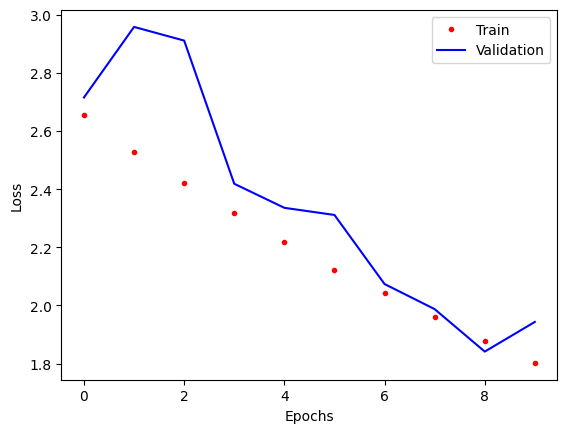

88/88 [==============================] - 3s 29ms/step


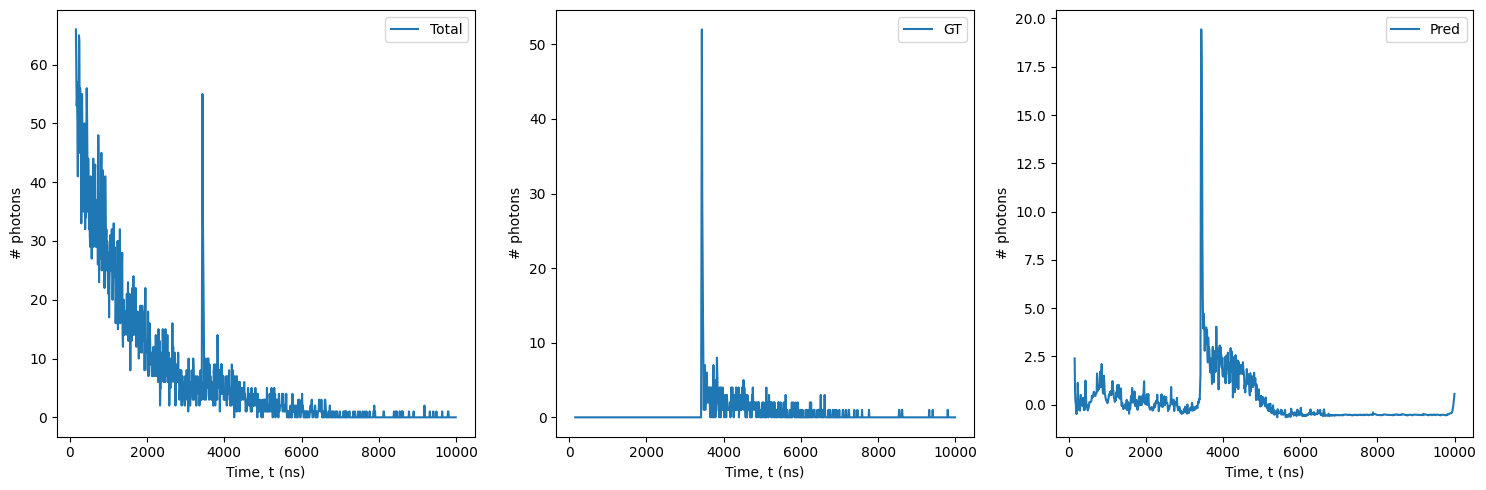

Ratio e total found: 59.578270192995%


In [14]:
callback = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True, 
                         mode='auto')

model = BN_Bidir_LSTM(n_blocks=1,
                      n_neurons=[32], 
                      activation=['tanh'], 
                      input_shape=input_shape)

model.compile(optimizer='RMSprop', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, 
                    validation_split=0.3, callbacks=callback)

testModel(model, history, X_test, y_test)

Epoch 1/10
143/143 [==============================] - 133s 905ms/step - loss: 2.5654 - val_loss: 4.5131
Epoch 2/10
143/143 [==============================] - 125s 873ms/step - loss: 2.0032 - val_loss: 4.1773
Epoch 3/10
143/143 [==============================] - 125s 875ms/step - loss: 1.6846 - val_loss: 1.7314
Epoch 4/10
143/143 [==============================] - 121s 845ms/step - loss: 1.4798 - val_loss: 1.4025
Epoch 5/10
143/143 [==============================] - 118s 823ms/step - loss: 1.3357 - val_loss: 1.3877
Epoch 6/10
143/143 [==============================] - 116s 815ms/step - loss: 1.2302 - val_loss: 1.1911
Epoch 7/10
143/143 [==============================] - 117s 817ms/step - loss: 1.1280 - val_loss: 1.1273
Epoch 8/10
143/143 [==============================] - 118s 823ms/step - loss: 1.0457 - val_loss: 1.0586
Epoch 9/10
143/143 [==============================] - 119s 831ms/step - loss: 0.9737 - val_loss: 1.0228
Epoch 10/10
143/143 [==============================] - 119s 829m

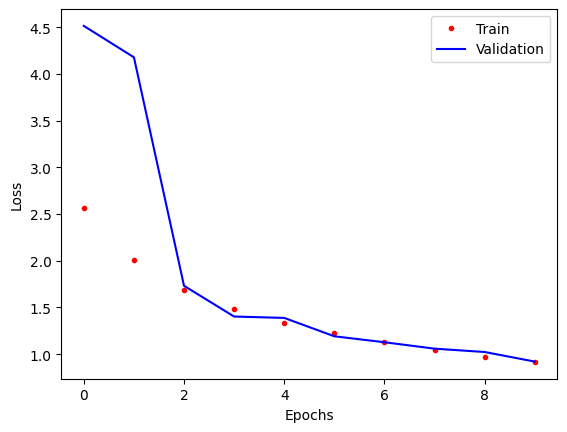

88/88 [==============================] - 14s 158ms/step


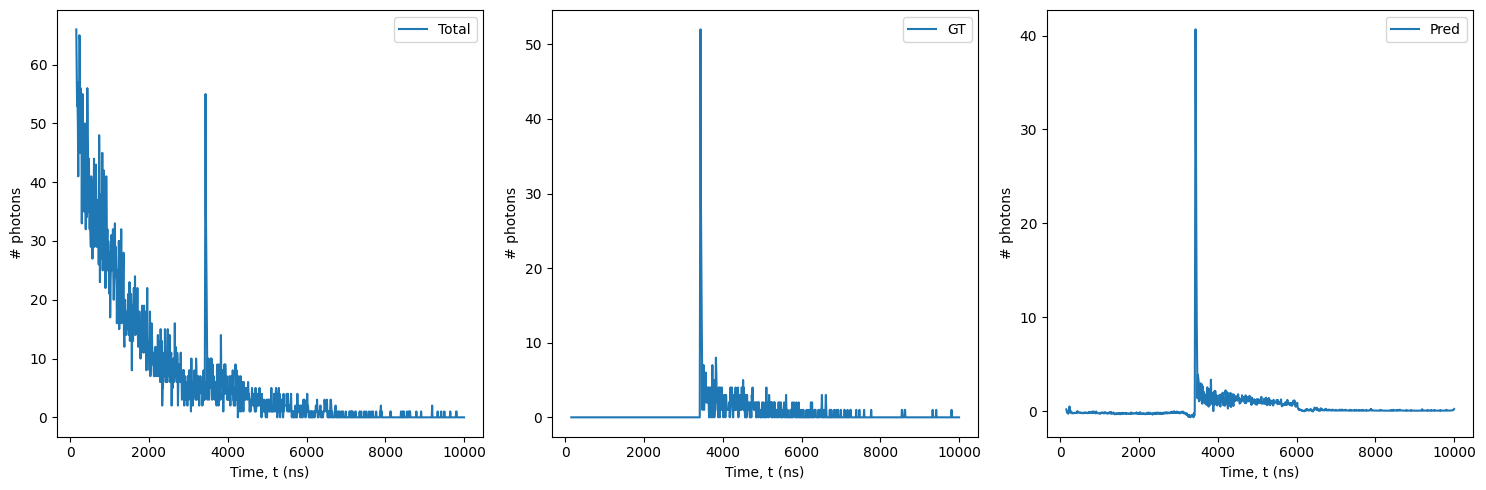

Ratio e total found: 45.282344531808434%


In [15]:
callback = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True, 
                         mode='auto')

model = BN_Bidir_LSTM(n_blocks=2,
                      n_neurons=[64, 64], 
                      activation=['tanh', 'tanh'], 
                      input_shape=input_shape)

model.compile(optimizer='RMSprop', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=10, 
                    validation_split=0.3, callbacks=callback)

testModel(model, history, X_test, y_test)

Epoch 1/30
143/143 [==============================] - 22s 145ms/step - loss: 2.6559 - val_loss: 2.7151
Epoch 2/30
143/143 [==============================] - 21s 145ms/step - loss: 2.5268 - val_loss: 2.9575
Epoch 3/30
143/143 [==============================] - 20s 143ms/step - loss: 2.4213 - val_loss: 2.9106
Epoch 4/30
143/143 [==============================] - 20s 143ms/step - loss: 2.3179 - val_loss: 2.4184
Epoch 5/30
143/143 [==============================] - 20s 142ms/step - loss: 2.2171 - val_loss: 2.3357
Epoch 6/30
143/143 [==============================] - 20s 141ms/step - loss: 2.1221 - val_loss: 2.3111
Epoch 7/30
143/143 [==============================] - 21s 145ms/step - loss: 2.0434 - val_loss: 2.0737
Epoch 8/30
143/143 [==============================] - 21s 146ms/step - loss: 1.9604 - val_loss: 1.9875
Epoch 9/30
143/143 [==============================] - 20s 143ms/step - loss: 1.8794 - val_loss: 1.8415
Epoch 10/30
143/143 [==============================] - 20s 143ms/step - l

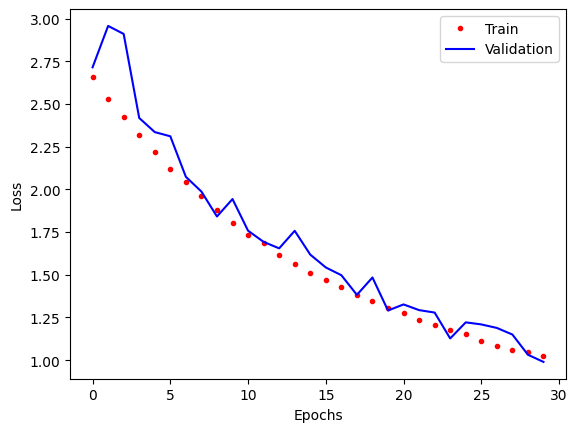

88/88 [==============================] - 3s 29ms/step


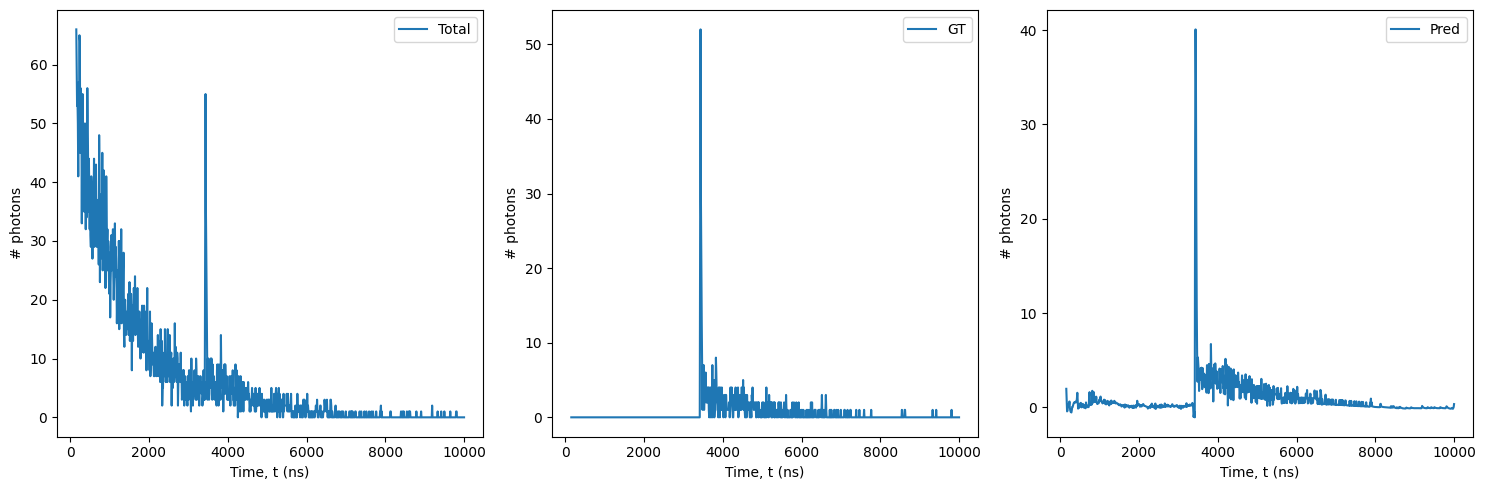

Ratio e total found: 55.03931379556827%


In [16]:
callback = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True, 
                         mode='auto')

model = BN_Bidir_LSTM(n_blocks=1,
                      n_neurons=[32], 
                      activation=['tanh'], 
                      input_shape=input_shape)

model.compile(optimizer='RMSprop', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=30, 
                    validation_split=0.3, callbacks=callback)

testModel(model, history, X_test, y_test)

Epoch 1/50
143/143 [==============================] - 23s 151ms/step - loss: 2.6559 - val_loss: 2.7151
Epoch 2/50
143/143 [==============================] - 22s 151ms/step - loss: 2.5268 - val_loss: 2.9575
Epoch 3/50
143/143 [==============================] - 21s 147ms/step - loss: 2.4213 - val_loss: 2.9106
Epoch 4/50
143/143 [==============================] - 20s 143ms/step - loss: 2.3179 - val_loss: 2.4184
Epoch 5/50
143/143 [==============================] - 20s 143ms/step - loss: 2.2171 - val_loss: 2.3357
Epoch 6/50
143/143 [==============================] - 20s 142ms/step - loss: 2.1221 - val_loss: 2.3111
Epoch 7/50
143/143 [==============================] - 20s 142ms/step - loss: 2.0434 - val_loss: 2.0737
Epoch 8/50
143/143 [==============================] - 20s 142ms/step - loss: 1.9604 - val_loss: 1.9875
Epoch 9/50
143/143 [==============================] - 20s 142ms/step - loss: 1.8794 - val_loss: 1.8415
Epoch 10/50
143/143 [==============================] - 20s 142ms/step - l

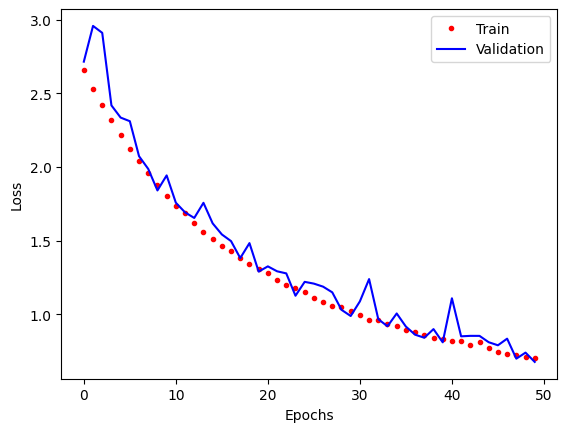

88/88 [==============================] - 3s 29ms/step


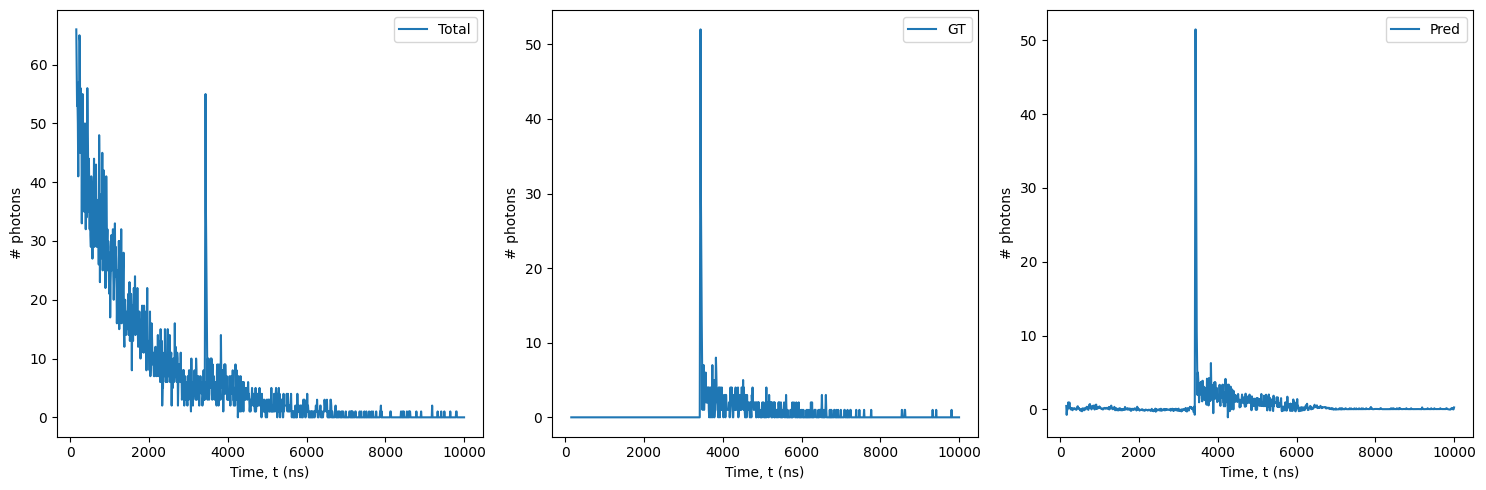

Ratio e total found: 58.112937812723374%


In [17]:
callback = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True, 
                         mode='auto')

model = BN_Bidir_LSTM(n_blocks=1,
                      n_neurons=[32], 
                      activation=['tanh'], 
                      input_shape=input_shape)

model.compile(optimizer='RMSprop', loss='mean_squared_error')
history = model.fit(X_train, y_train, batch_size=32, epochs=50, 
                    validation_split=0.3, callbacks=callback)

testModel(model, history, X_test, y_test)

In [20]:
from keras.saving import load_model

MODELS = os.path.join(PATH, os.path.join('scripts', os.path.join('python', 'models')))
model.save(os.path.join(MODELS, 'BN_BiLSTM_small.keras.keras'), overwrite=True, 
           save_format='tf')

In [21]:
max_photons = 5
max_values = e_signals.max(axis=1)

mask = max_values > max_photons # True those with a maximum > max_photons
e_idxs = mask[mask==True].index.values

print('Total series: ', e_signals.shape[0])
print('Number of e signals with a max>{0}: {1}'.format(max_photons, e_idxs.shape[0]))

Xf = np.array(signals.loc[e_idxs, t_idx].values)
yf = np.array(e_signals.loc[e_idxs, t_idx].values)

Total series:  9325
Number of e signals with a max>5: 4223


132/132 [==============================] - 4s 28ms/step


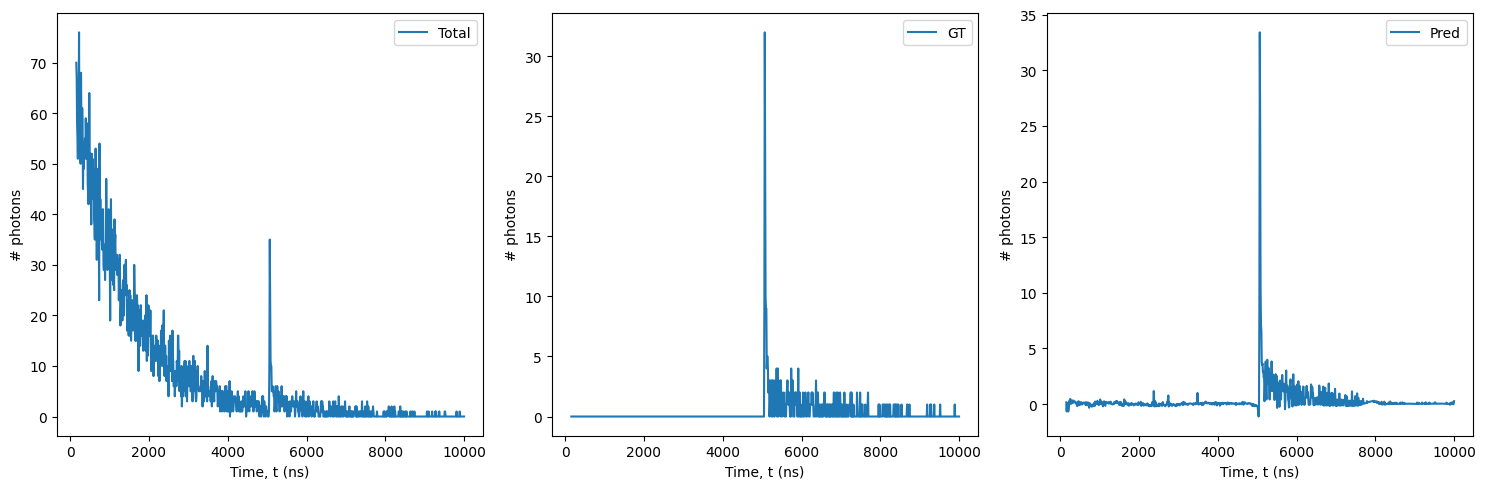

Ratio e total found: 80.10892730286527%


In [22]:
testModel(model, None, Xf[:,:,np.newaxis].astype('float64'), yf)

## Using $\mu$ signal as a feature

As we can see from the earlier figures, the NN is capable of extracting the data.  
Now, let's create an equal model that also receives the signal of the muon as a 
feature:

In [18]:
X = np.array(signals.loc[idxs[i], t_idx]).reshape(-1,1)
X_m = np.array([X, b])
X_m.shape
# y = a

(2, 985, 1)

In [19]:
model = Sequential()
model.add(LSTM(units=50, activation = 'sigmoid', input_shape=(985,1)))
model.add(Dense(1, activation='linear'))

Epoch 1/50
1/1 [==============================] - 1s 622ms/step - loss: 8.1316e-08 - val_loss: 0.0022
Epoch 2/50
1/1 [==============================] - 0s 103ms/step - loss: 0.0022 - val_loss: 1.5470e-05
Epoch 3/50
1/1 [==============================] - 0s 101ms/step - loss: 1.5470e-05 - val_loss: 0.0015
Epoch 4/50
1/1 [==============================] - 0s 102ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 5/50
1/1 [==============================] - 0s 107ms/step - loss: 0.0013 - val_loss: 2.0408e-04
Epoch 6/50
1/1 [==============================] - 0s 104ms/step - loss: 2.0409e-04 - val_loss: 1.1898e-04
Epoch 7/50
1/1 [==============================] - 0s 102ms/step - loss: 1.1898e-04 - val_loss: 7.5396e-04
Epoch 8/50
1/1 [==============================] - 0s 105ms/step - loss: 7.5396e-04 - val_loss: 8.5358e-04
Epoch 9/50
1/1 [==============================] - 0s 101ms/step - loss: 8.5358e-04 - val_loss: 3.6104e-04
Epoch 10/50
1/1 [==============================] - 0s 99ms/step - loss

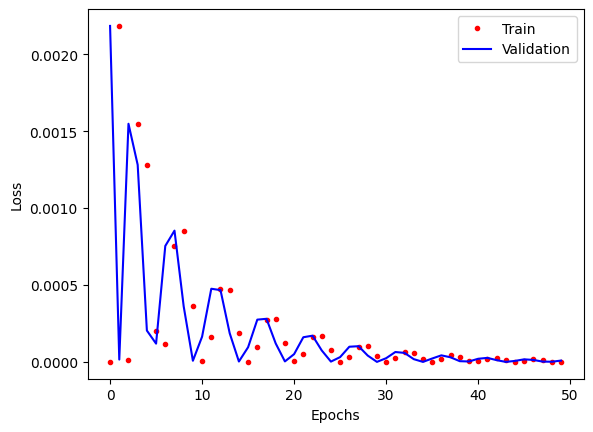

In [24]:
model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_m, a, batch_size=30, epochs=50, 
                    validation_split=0.1)
NN_trainPlot(history)

In this case, this little neural network achieves to minimize the loss in 
validation and not overfitting. This implies that adding the signal of the muon 
as a features is a good option.

31/31 [==============================] - 0s 532us/step


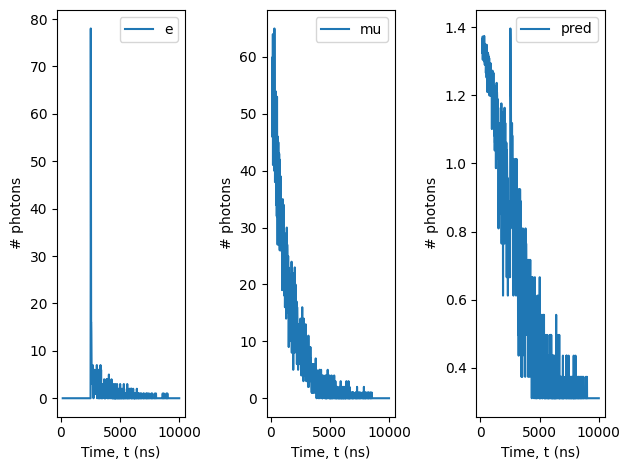

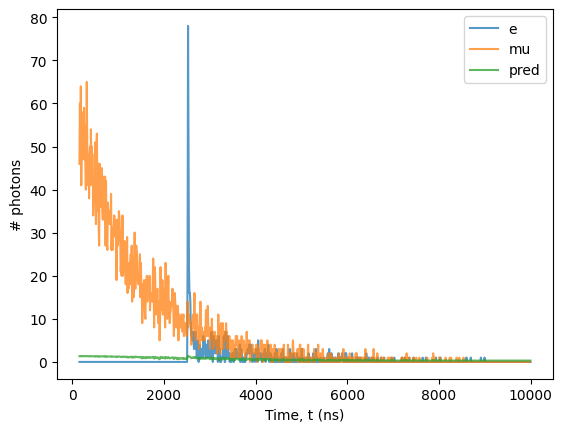

In [26]:
pred = model.predict(X)

v = [a, b, np.array(-pred).reshape(-1,1)]
plotSignals(t, v, ['e', 'mu', 'pred'], sep=True)
plotSignals(t, v, ['e', 'mu', 'pred'], sep=False)

When predicting, we have still the same problem it seems the predicted serie is 
too low although the loss 